In [8]:

####Rene 7_30_2021 update 4/1/2022
# Import the os module
import os
import pandas as pd
import numpy as np

#Generate clusters of ms features across depth.
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize

#This file is for development. Main functions are embedded here.

# Change the current working directory
os.chdir('/Users/boiteaur/Desktop/CoreMS_metallomics/CoreMS')

###### Set file folder and THERMO RAW file name here:
file_location='/Users/boiteaur/Desktop/Major projects/Bermuda Atlantic Time Series data processing/Thermo RAW data'
files=os.listdir('/Users/boiteaur/Desktop/Major projects/Bermuda Atlantic Time Series data processing/Thermo RAW data')

import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("./")
from pathlib import Path
import matplotlib.pyplot as plt


from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import matplotlib.backends.backend_pdf

## This points to the reference mass list used for calibration. 
refmasslist = Path.cwd() / "tests/tests_data/ftms/nom_pos_2.ref"

#Set peak detection threshold method
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.25
MSParameters.molecular_search.max_ppm_error = 0.25

MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = -1
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,4)
#MSParameters.molecular_search.usedAtoms['S'] = (0,0)

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"
#Read in sample list and load MS data

samplelist=pd.read_csv(file_location+'/'+'BATS_samplelist.csv')

MSfiles={}
for file in samplelist['File'][samplelist['type']=='sample']:
#for file in samplelist.File:
    parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file_location+'/'+file)
    MSfiles[file]=parser

samplelist=samplelist[samplelist['File'].isin(MSfiles.keys())]

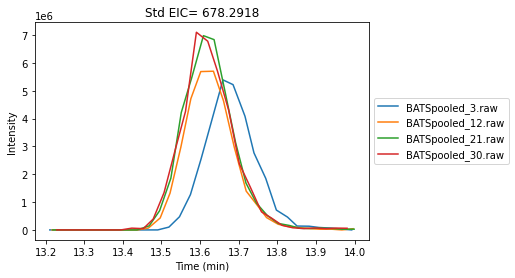

0
pass of
0
13.3 % std dev
34462632.91503906 % std dev


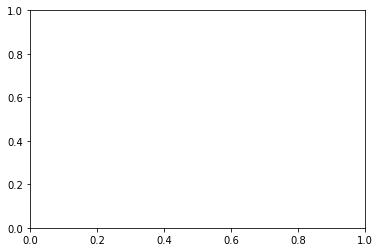

In [6]:
#QC control 

stdmass=678.2918
std_timerange=[13.2,14]

#QC control 

#stdmass=389.1960
#std_timerange=[5,30]

area=[]
rt=[]
fig=plt.figure()
ax=plt.subplot(111)
ax.set(xlabel='Time (min)',ylabel='Intensity',title='Std EIC= '+str(stdmass))

for file in MSfiles.keys():
    EIC=MSfiles[file].get_eics(target_mzs=[stdmass],tic_data={},peak_detection=False,smooth=False)
    df=pd.DataFrame({'EIC':EIC[0][stdmass].eic,'time':EIC[0][stdmass].time})
    df_sub=df[df['time'].between(std_timerange[0],std_timerange[1])]
    area.append(sum(df_sub['EIC']))
    rt.append(df_sub.time[df_sub.EIC==df_sub.EIC.max()].max())
    ax.plot(df_sub['time'],df_sub['EIC'],label=file[11:])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

samplelist['qc_area']=area
samplelist['qc_rt']=rt

#plt.savefig('Fig1_qcplot.eps', format='eps')

plt.show()

peak_stdv=samplelist[samplelist.type=='sample'].qc_area.std()
peak_mean=samplelist[samplelist.type=='sample'].qc_area.mean()

#samplelist[samplelist.type=='sample'].boxplot(column=['qc_area'])
sns.histplot(x='qc_area',data=samplelist[samplelist.type=='sample'],kde=True)
#sns.violinplot(x='qc_area',data=samplelist[samplelist.type=='sample'])

#sns.violinplot(x='qc_rt',data=samplelist[samplelist.type=='sample'])


samplelist['qc_pass']=0
for i in samplelist.index:
    if (abs(samplelist.qc_area[i]-peak_mean)<2*peak_stdv):
        samplelist.qc_pass[i]=1

print(samplelist[samplelist.type=='sample'].qc_pass.sum())
print('pass of')
print(len(samplelist[samplelist.type=='sample']))

peak_stdv=samplelist[samplelist.qc_pass==1].qc_area.std()
peak_mean=samplelist[samplelist.qc_pass==1].qc_area.mean()
peak_stdv=samplelist.qc_area.std()
peak_mean=samplelist.qc_area.mean()

print(str(round(peak_stdv/peak_mean*100,1))+' % std dev')
print(str(peak_mean)+' % std dev')

In [179]:
print(samplelist.qc_area)
print(peak_mean)

4     6.054052e+07
5     4.991689e+07
6     5.779780e+07
7     5.158908e+07
8     5.011799e+07
9     6.201062e+07
10    6.856649e+07
11    4.333153e+07
12    4.524377e+07
13    4.816667e+07
14    5.101583e+07
15    5.097111e+07
16    4.830752e+07
17    5.576113e+07
18    6.554262e+07
19    5.450508e+07
20    5.217838e+07
21    5.545543e+07
22    5.333955e+07
23    1.664097e+08
Name: qc_area, dtype: float64
53913580.16627262


In [181]:
53913580.16627262/1.66e8



0.32478060341128084

In [3]:
#Function to build formula assignment lists
#Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 
interval=2
timerange=[4,26]

B=21 #magnetic field strength
T=0.6 #transient time

def lcmsformula(parser,interval,timerange):
    tic=parser.get_tic(ms_type='MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})

    times=list(range(timerange[0],timerange[1],interval))

    results=[]
    
    for timestart in times:

        scans=tic_df[tic_df.time.between(timestart,timestart+interval)].scan.tolist()

        #Now, get an average mass spectrum and list the centroided m/z values of the spectrum. One of these should be the molecule of interest.
        mass_spectrum = parser.get_average_mass_spectrum_by_scanlist(scans)

        #This filters based on resolving power to remove noise. Assumes ICR-MS. 
        mass_spectrum.filter_by_min_resolving_power(B, T)
    
        mass_spectrum.settings.min_calib_ppm_error = 2
        mass_spectrum.settings.max_calib_ppm_error = -2
        #mass_spectrum.mass_spectrum.settings.calib_sn_threshold
        #mass_spectrum.mass_spectrum.settings.calib_pol_order
        #mass_spectrum.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)
        #MzDomainCalibration(mass_spectrum, ref_file_location).run()
        calfn = MzDomainCalibration(mass_spectrum, refmasslist)
        ref_mass_list_fmt = calfn.load_ref_mass_list(refmasslist)

        imzmeas, mzrefs = calfn.find_calibration_points(mass_spectrum, ref_mass_list_fmt,
                                                    calib_ppm_error_threshold=(-2.0, 2.0),
                                                    calib_snr_threshold=3)

        calfn.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)


        SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

        mass_spectrum.percentile_assigned(report_error=True)

        assignments=mass_spectrum.to_dataframe()

        assignments['Time']=timestart

        results.append(assignments)
        #results(timestart)=assignments[assignments['Calculated m/z']>1].filter(['m/z','corr','Peak Height','Confidence Score','Molecular Formula','Time']))
    
    results=pd.concat(results,ignore_index=True)

    return(results)

In [4]:
#### LCMS batch formula assignment function.
masterresults={}

for file in MSfiles:
    print(file)
    results=lcmsformula(MSfiles[file],interval,timerange)
    results['File']=file
    masterresults[file]=results

#This will create masterresults_df from above masterresults and save
masterresults_df=pd.concat(masterresults.values())
masterresults_df.to_csv(file_location+'masterresults_5.csv')

RMB_190828_BATS05_300m.raw
MS Obj loaded - 332 peaks found.
MS Obj loaded - 332 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
187 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.039 ppm
minimize function performed 366 fn evals and 7 iterations
'runworker'  2599.89 ms


Loading molecular formula database: 84098it [00:06, 13758.16it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:00<00:00, 118.80it/s]


'run_molecular_formula'  9658.63 ms
281 assigned peaks and 51 unassigned peaks, total  = 84.64 %, relative abundance = 72.88 %, RMS error (best candidate) (ppm) = 0.054
MS Obj loaded - 499 peaks found.
MS Obj loaded - 499 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
296 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.043 ppm
minimize function performed 321 fn evals and 6 iterations
'runworker'  1428.84 ms


Loading molecular formula database: 84098it [00:07, 11694.23it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 70.55it/s]


'run_molecular_formula'  10172.61 ms
457 assigned peaks and 42 unassigned peaks, total  = 91.58 %, relative abundance = 85.85 %, RMS error (best candidate) (ppm) = 0.052
MS Obj loaded - 628 peaks found.
MS Obj loaded - 628 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
363 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.047 ppm
minimize function performed 322 fn evals and 6 iterations
'runworker'  888.28 ms


Loading molecular formula database: 84098it [00:06, 12717.04it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 79.39it/s]


'run_molecular_formula'  8869.43 ms
593 assigned peaks and 35 unassigned peaks, total  = 94.43 %, relative abundance = 93.37 %, RMS error (best candidate) (ppm) = 0.059
MS Obj loaded - 577 peaks found.
MS Obj loaded - 577 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
364 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.049 ppm
minimize function performed 323 fn evals and 6 iterations
'runworker'  1451.32 ms


Loading molecular formula database: 84098it [00:07, 11687.42it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 83.72it/s]


'run_molecular_formula'  9943.02 ms
565 assigned peaks and 12 unassigned peaks, total  = 97.92 %, relative abundance = 98.04 %, RMS error (best candidate) (ppm) = 0.059
MS Obj loaded - 613 peaks found.
MS Obj loaded - 613 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
405 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.034 ppm
minimize function performed 3029 fn evals and 69 iterations
'runworker'  1027.25 ms


Loading molecular formula database: 84098it [00:07, 10901.16it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 79.18it/s]


'run_molecular_formula'  10185.80 ms
595 assigned peaks and 18 unassigned peaks, total  = 97.06 %, relative abundance = 95.99 %, RMS error (best candidate) (ppm) = 0.042
MS Obj loaded - 726 peaks found.
MS Obj loaded - 726 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
434 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.035 ppm
minimize function performed 3006 fn evals and 69 iterations
'runworker'  824.86 ms


Loading molecular formula database: 84098it [00:07, 11386.45it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 65.11it/s]


'run_molecular_formula'  9855.16 ms
711 assigned peaks and 15 unassigned peaks, total  = 97.93 %, relative abundance = 98.06 %, RMS error (best candidate) (ppm) = 0.049
MS Obj loaded - 781 peaks found.
MS Obj loaded - 781 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
428 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.037 ppm
minimize function performed 3013 fn evals and 72 iterations
'runworker'  1252.75 ms


Loading molecular formula database: 84098it [00:08, 10217.78it/s]
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:01<00:00, 78.04it/s]


'run_molecular_formula'  10869.90 ms
757 assigned peaks and 24 unassigned peaks, total  = 96.93 %, relative abundance = 96.84 %, RMS error (best candidate) (ppm) = 0.048
MS Obj loaded - 878 peaks found.
MS Obj loaded - 878 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
421 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.042 ppm
minimize function performed 464 fn evals and 10 iterations
'runworker'  2344.04 ms


Loading molecular formula database: 84098it [00:10, 8366.88it/s] 
Started molecular formula search for class {"N": 4, "O": 20}, (de)protonated : 100%|██████████| 100/100 [00:02<00:00, 45.87it/s]


'run_molecular_formula'  14724.37 ms
861 assigned peaks and 17 unassigned peaks, total  = 98.06 %, relative abundance = 98.37 %, RMS error (best candidate) (ppm) = 0.049


KeyboardInterrupt: 

In [10]:
#masterresults_df=pd.concat(masterresults.values())
#masterresults_df.to_csv(file_location+'masterresults_2.csv')

Text(0, 0.5, 'Fraction of peaks resolved')

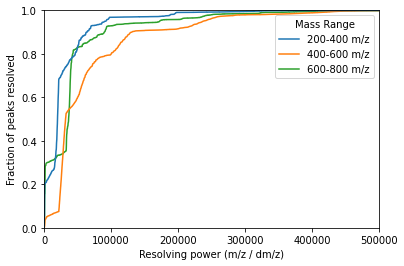

In [9]:
#Make plots showing required resolving power.

#This will load a previous masterresults_df
masterresults_df=pd.read_csv(file_location+'masterresults_5.csv')

#Note, this line filters masterresults to only contain samples.
masterresults_df=masterresults_df[masterresults_df.File.isin(samplelist.File[samplelist.type=='sample'])]

#Calculate required resolving power
res_summary=[]
mzinterval=200
mzint=range(200,800,mzinterval)
for time in masterresults_df['Time'].unique():
    
    result=masterresults_df[masterresults_df['Time']==time]

    for file in masterresults_df['File'].unique():

        result_sub=result[result['File']==file]

        for mz in mzint:
            result_sub_mz=result_sub[(result_sub['m/z']>mz) & (result_sub['m/z'] < mz + mzinterval)]
            mzvalues=result_sub_mz['m/z'].sort_values(ascending=True)
            differences=mzvalues.diff()
            #Resolve from peaks on either side
            mzdiff=pd.DataFrame({'left':differences[1:-1].to_list(),'right':differences[2:].to_list()})
            mzdiff=mzdiff.min(axis=1)
            mzvalues=mzvalues.iloc[1:-1].reset_index()['m/z']
            #mzdiff_res=mzvalues/mzdiff*2
            mzdiff_res=mzvalues/mzdiff*2
            for i in mzdiff_res.index:
                res_summary.append({'resolution':mzdiff_res[i],'mass':mzvalues[i],'Mass Range':str(mz)+'-'+str(mz+mzinterval) + ' m/z','file':file,'time':time})

res_summary_df=pd.DataFrame(res_summary)
fig, (ax) = plt.subplots(1)
sns.ecdfplot(x='resolution',hue='Mass Range',data=res_summary_df,ax=ax)
ax.set_xlim(0,500000)
ax.set_xlabel('Resolving power (m/z / dm/z)')
ax.set_ylabel('Fraction of peaks resolved')
#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


time4
O/C:0.3753646528339649
H/C:1.3613153509501665
time6
O/C:0.37694741946815236
H/C:1.3481538825457713
time8
O/C:0.372395563418169
H/C:1.3370558869224447
time10
O/C:0.3603001685428143
H/C:1.3499683718387723
time12
O/C:0.3478102762615681
H/C:1.3680932614518657
time14
O/C:0.33478399971147743
H/C:1.3895408226482087
time16
O/C:0.3168107086215712
H/C:1.4037291931623648
time18
O/C:0.2991889185040016
H/C:1.4223674379204676
time20
O/C:0.28059969729465023
H/C:1.4374584961314931
time22
O/C:0.262708335007938
H/C:1.4566415304532285
time24
O/C:0.24736648181139734
H/C:1.4753910557748806


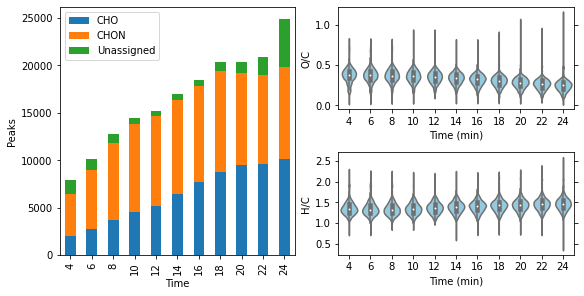

In [10]:
# Generate 'results' data frame that describes molecular stoichiometries and molecular classes. 
# Generates plot of number of assigned peaks based on classes. 

allresults=masterresults_df[(masterresults_df['m/z']<800)]

allresults['N']=allresults['N'].fillna(0)
allresults['O']=allresults['O'].fillna(0)
allresults['Peak Height']=allresults['Peak Height'].fillna(0)
#allresults['S']=allresults['S'].fillna(0)
#allresults['P']=allresults['P'].fillna(0)
#allresults['Na']=allresults['Na'].fillna(0)

allresults['mol_class']='Unassigned'
allresults['mol_class'][allresults['C']>0]='CHO'
allresults['mol_class'][(allresults['C']>0) & (allresults['N']>0.5)]='CHON'

results= allresults[allresults['Is Isotopologue']==0]
results['O/C']=results['O']/results['C']
results['H/C']=results['H']/results['C']
results['N/C']=results['N']/results['C']

#fig, (ax) = plt.subplots(1)
#sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='File',data=results,ax=ax)
#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

assign_summary=[]
for time in allresults['Time'].unique():
    current={}
    current['Time']=time
    for mol_class in sorted(allresults['mol_class'].unique()):
        current[mol_class]=len(allresults[(allresults['mol_class']==mol_class) & (allresults['Time']==time)])
    assign_summary.append(current)
df=pd.DataFrame(assign_summary)

fig, axs = plt.subplot_mosaic([['a','b'],['a','c']], figsize=(8,4), constrained_layout=True)
df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=axs['a'])

sns.violinplot(x="Time", y="O/C", data=results, ax=axs['b'], legend=False, color='skyblue')
axs['b'].set(xlabel='Time (min)')
axs['b'].tick_params(right=True)
sns.violinplot(x="Time", y="H/C", data=results, ax=axs['c'], legend=False, color='skyblue')
axs['c'].set(xlabel='Time (min)')
axs['c'].tick_params(right=True)

for time in results.Time.unique():
    print("time" + str(time))
    print('O/C:'+str(results[results.Time==time]['O/C'].mean()))
    print('H/C:'+str(results[results.Time==time]['H/C'].mean()))

#fig, axs = plt.subplots(1,3)
#fig.set_size_inches(8, 3)
#fig.tight_layout()

#df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=axs[0])
#sns.violinplot(x="Time", y="O/C", data=results, ax=axs[1], legend=False, color='skyblue')
#axs[1].set(xlabel='Time (min)')
#sns.violinplot(x="Time", y="H/C", data=results, ax=axs[2], legend=False, color='skyblue')
#axs[2].set(xlabel='Time (min)')

plt.show()


In [11]:
calc=pd.DataFrame(assign_summary)
fraction_Assigned=calc.Unassigned/(calc.CHO+calc.CHON+calc.Unassigned)
print(fraction_Assigned)

0     0.178803
1     0.114894
2     0.073321
3     0.042446
4     0.033564
5     0.037355
6     0.036212
7     0.047141
8     0.060569
9     0.092721
10    0.204483
dtype: float64


All results length: 182473
Monoisotopic results length: 151610
All Unique results: 13273
Unique results, S/N>3: 10074
Unique results, blank subtracted: 9162
Unique results, min thresh: 8379
Unique molecular formula: 2165


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


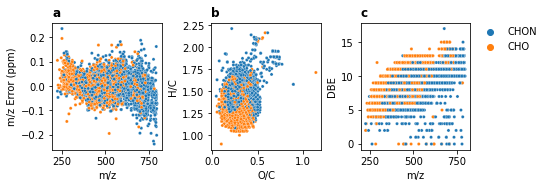

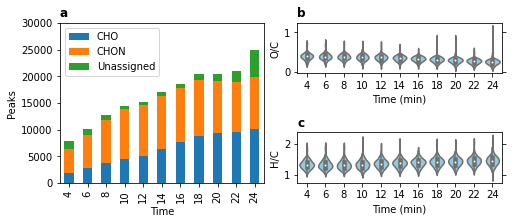

In [17]:
print("All results length: " + str(len(allresults)))
print("Monoisotopic results length: " + str(len(results)))

#Create a list of all unique features and their abundances across samples. . 
uniquelist=[]
for time in results.Time.unique():
    current=results[results.Time==time]
    current=current.sort_values(by=['Peak Height'],ascending=False)
    currentunique=current.drop_duplicates(subset=['Molecular Formula'])
    currentunique=currentunique.set_index(['Molecular Formula'],drop=False)
    for file in results['File'].unique():
        #current_file=current[current['File']==file].drop_duplicates(subset=['Molecular Formula'])
        #print(len(current))
        current_file=current[current['File']==file]
        #print(len(current))
        current_file=current_file.rename(columns={'Peak Height':file})
        current_file=current_file.set_index(['Molecular Formula'],drop=False)
        currentunique=currentunique.join(current_file[file])
    uniquelist.append(currentunique)

uniqueresults=pd.concat(uniquelist,ignore_index=True)
print("All Unique results: " + str(len(uniqueresults)))

#remove low abundance hits
uniqueresults=uniqueresults[uniqueresults["S/N"]>3]
print("Unique results, S/N>3: " + str(len(uniqueresults)))

#remove blank hits
uniqueresults['blank']=uniqueresults['RMB_190828_BATS24_blnk.raw'].fillna(0)/uniqueresults['Peak Height']
uniqueresults=uniqueresults[uniqueresults['blank']<0.5]
print("Unique results, blank subtracted: " + str(len(uniqueresults)))
#print("Unique molecular formula: " + str(len(uniqueresults['Molecular Formula'].unique())))

#remove hits that don't appear in a minimum of 5 samples:
uniqueresults['occurrence']=uniqueresults[results['File'].unique()].gt(0).sum(axis=1)
uniqueresults=uniqueresults[uniqueresults['occurrence']>4.5]

print("Unique results, min thresh: " + str(len(uniqueresults)))
print("Unique molecular formula: " + str(len(uniqueresults['Molecular Formula'].unique())))

#### Figure

fig, axs = plt.subplot_mosaic([['a','b','c']], figsize=(7.5,2.5), constrained_layout=True)

sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='mol_class',data=uniqueresults,ax=axs['a'],s=10, legend=False)
#axs['a'].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs['a'].set_title('a', fontweight='bold', loc='left')

sns.scatterplot(x='O/C',y='H/C',hue='mol_class',data=uniqueresults,ax=axs['b'],s=10, legend=False)
#axs['a'].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs['b'].set_title('b', fontweight='bold', loc='left')

sns.scatterplot(x='m/z',y='DBE',hue='mol_class',data=uniqueresults,ax=axs['c'],s=10)
axs['c'].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
axs['c'].set_title('c', fontweight='bold', loc='left')


fig.savefig(file_location+'CoreLCMS_FigS4.eps',dpi=300,format='eps')
fig.savefig(file_location+'CoreLCMS_FigS4.pdf',dpi=300,format='pdf')


#### Figure

fig, axs = plt.subplot_mosaic([['a','b'],['a','c']], figsize=(7,3), constrained_layout=True)
#fig, axs = plt.subplot_mosaic([['a'],['b'],['c']], figsize=(3.5,8), constrained_layout=True)

df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=axs['a'])
#axs['a'].text(-0.1, 1.15, 'a', transform=ax.transAxes, fontweight='bold', va='top', ha='right')
axs['a'].set_title('a', fontweight='bold', loc='left')
axs['a'].set_ylim(0,30000)

sns.violinplot(x="Time", y="O/C", data=uniqueresults, ax=axs['b'], legend=False, color='skyblue')
axs['b'].set(xlabel='Time (min)')
axs['b'].tick_params(right=True)
axs['b'].set_title('b', fontweight='bold', loc='left')

sns.violinplot(x="Time", y="H/C", data=uniqueresults, ax=axs['c'], legend=False, color='skyblue')
axs['c'].set(xlabel='Time (min)')
axs['c'].tick_params(right=True)
axs['c'].set_title('c', fontweight='bold', loc='left')

fig.savefig(file_location+'CoreLCMS_Fig2.eps',dpi=300,format='eps')
fig.savefig(file_location+'CoreLCMS_Fig2.pdf',dpi=300,format='pdf')

uniqueresults.to_csv(file_location+'unique_results.csv')


In [18]:
### Develop dispersity index. 
EIC={}
for file in uniqueresults['File'].unique():
    masses=uniqueresults[uniqueresults['File']==file]['m/z'].unique().tolist()
    EIC[file]=MSfiles[file].get_eics(target_mzs=masses,tic_data={},peak_detection=False,smooth=False)
    
dispersity=[]
for ind in uniqueresults.index:
    current=uniqueresults.loc[ind]
    time=[0,2]+current.Time
    file=current.File
    mass=current['m/z']
    chroma=pd.DataFrame({'EIC':EIC[file][0][mass].eic,'time':EIC[file][0][mass].time})
    chroma=chroma[chroma['time'].between(time[0],time[1])]
    chroma=chroma.sort_values(by='EIC',ascending=False)
    d=chroma[chroma.cumsum()['EIC']<0.5*chroma.sum()['EIC']].time.std()
    dispersity.append(d)

uniqueresults['Dispersity']=dispersity

#uniqueresults.to_csv(file_location+'unique_results.csv')


8379


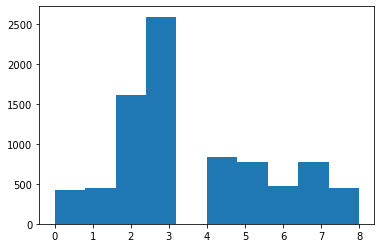

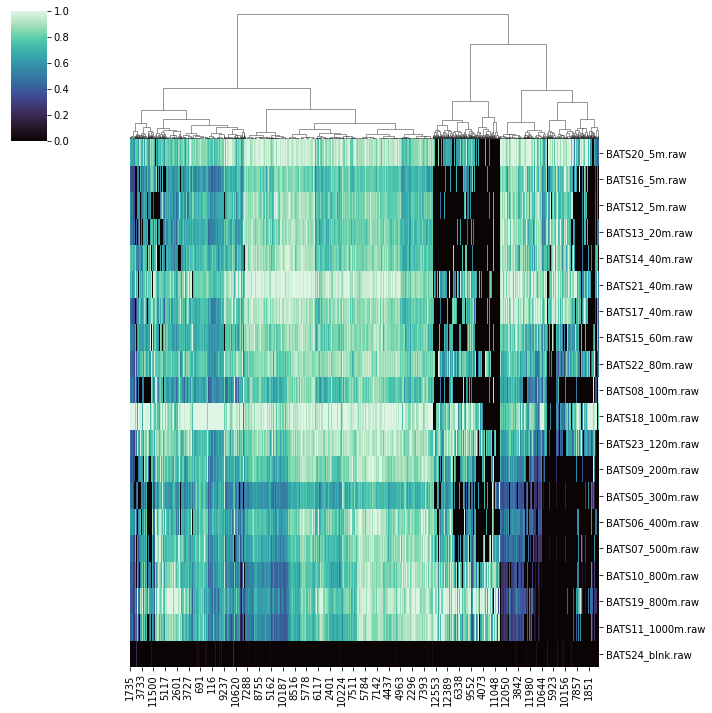

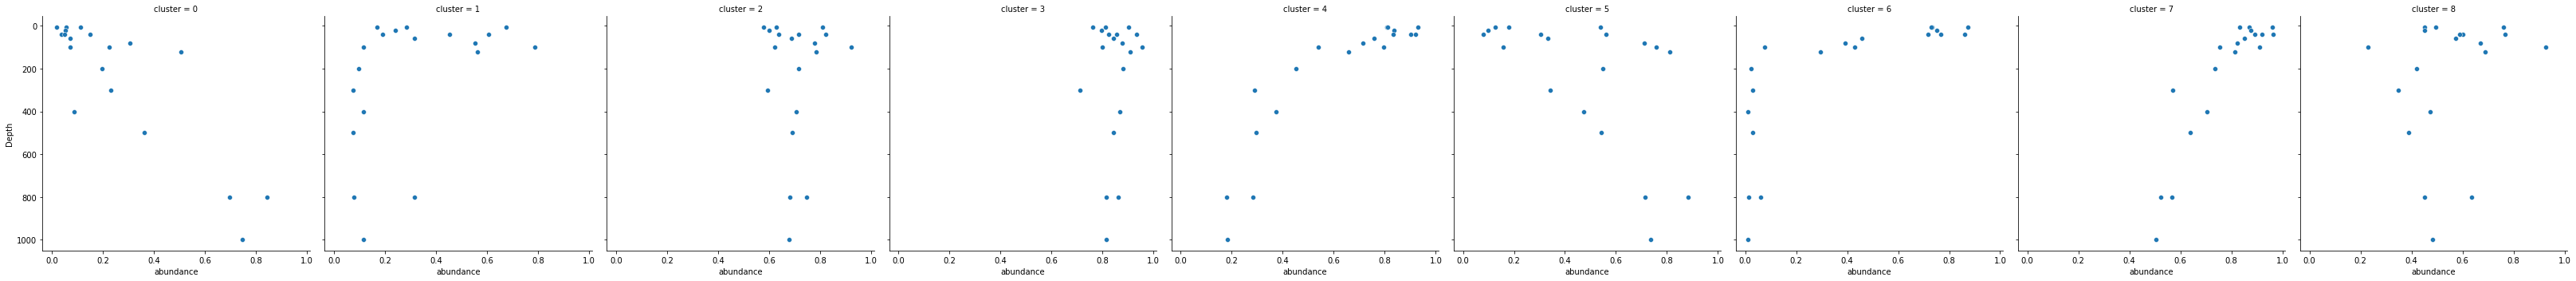

In [19]:
#Generate clusters of ms features across depth.
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize

###### Cluster settings
#clustermethod='average'
#clustermethod='complete'
clustermethod='ward'
nclusters=9

##################

results_clustered=uniqueresults

norm_abundances=results_clustered[masterresults_df['File'].unique()].fillna(0)
norm_abundances=norm_abundances.div(norm_abundances.max(axis=1),axis=0)


cluster = AgglomerativeClustering(n_clusters=nclusters,affinity='euclidean',linkage=clustermethod)
cluster.fit_predict(norm_abundances)
plt.hist(cluster.labels_)

results_clustered['cluster']=cluster.labels_

print(len(results_clustered))
#results_clustered.fillna(0).to_csv(file_location+'clustered_results.csv')


results_clustered.to_csv(file_location+'clustered_results.csv')

depth=[]
for file in masterresults_df['File'].unique():
    d=samplelist[samplelist['File']==file]['Depth'].iloc[0]
    depth.append(d)

clustered_results=[]
for i in results_clustered['cluster'].unique():
    current=pd.DataFrame({'abundance':norm_abundances[results_clustered['cluster']==i].sum(axis=0)/len(results_clustered[results_clustered['cluster']==i]),'Depth':depth,'cluster':i})
    clustered_results.append(current)

clustered_results=pd.concat(clustered_results)
clustered_results=clustered_results.sort_values(by='Depth',ascending=True)

#Make cluster heatmap
clusterplot=norm_abundances
clusterplot=clusterplot.transpose()
clusterplot['Depth']=depth
clusterplot=clusterplot.sort_values(by='Depth')
clusterplot=clusterplot.drop(['Depth'],axis=1)
#print(clusterplot.index.to_list())
g=clusterplot.index.to_list()
g[:]=(elem[11:] for elem in g)
clusterplot.index=g

sns.clustermap(clusterplot,row_cluster=False,cmap='mako',method=clustermethod)

g = sns.relplot(data=clustered_results, col='cluster', x='abundance', y='Depth', kind='scatter')
for ax in g.axes[0]:
    ax.invert_yaxis()

plt.show()

results_clustered['NOSC'] =  4 -(4*results_clustered['C'] + results_clustered['H'] - 3*results_clustered['N'] - 2*results_clustered['O'])/results_clustered['C']
results_clustered=results_clustered.sort_values(by='cluster')

<AxesSubplot:label='f', xlabel='NOSC', ylabel='Density'>

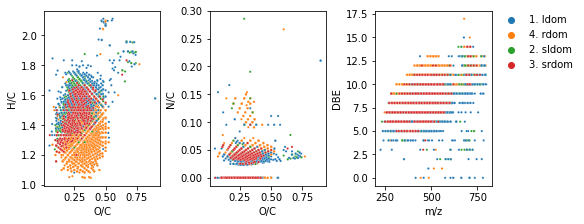

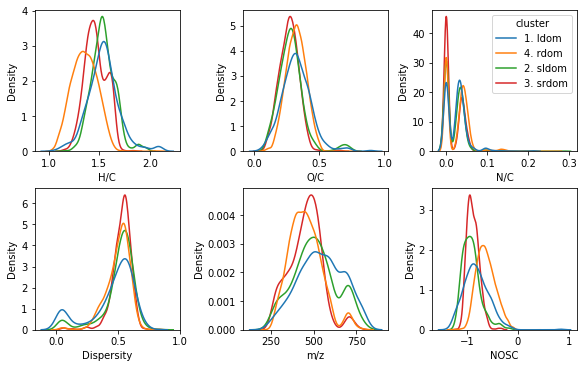

In [20]:
results_clustered['NOSC'] =  4 -(4*results_clustered['C'] + results_clustered['H'] - 3*results_clustered['N'] - 2*results_clustered['O'])/results_clustered['C']
results_clustered=results_clustered.sort_values(by='cluster')

#describe sample depth:
#Define clusters:
results_clustered.cluster[results_clustered.cluster==0]='out'
results_clustered.cluster[results_clustered.cluster==1]='1. ldom'
results_clustered.cluster[results_clustered.cluster==2]='4. rdom'
results_clustered.cluster[results_clustered.cluster==3]='4. rdom'
results_clustered.cluster[results_clustered.cluster==4]='2. sldom'
results_clustered.cluster[results_clustered.cluster==5]='out'
results_clustered.cluster[results_clustered.cluster==6]='1. ldom'
results_clustered.cluster[results_clustered.cluster==7]='3. srdom'
results_clustered.cluster[results_clustered.cluster==8]='out'

results_clustered=results_clustered[results_clustered.cluster!='out']
#results_clustered=results_clustered[results_clustered['S/N']>7]


fig, axs = plt.subplot_mosaic([['a','b','c']], figsize=(8,3), constrained_layout=True)
sns.scatterplot(x='O/C',y='H/C',hue='cluster',s=5,data=results_clustered, ax=axs['a'],legend=False)
sns.scatterplot(x='O/C',y='N/C',hue='cluster',s=5,data=results_clustered, ax=axs['b'],legend=False)
sns.scatterplot(x='m/z',y='DBE',hue='cluster',s=5,data=results_clustered, ax=axs['c'],legend=True)
axs['c'].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)

fig2, axs = plt.subplot_mosaic([['a','b','c'],['d','e','f']], figsize=(8,5), constrained_layout=True)
sns.kdeplot(x='H/C',hue='cluster', data=results_clustered, ax=axs['a'], common_norm=False,legend=False)
sns.kdeplot(x='O/C',hue='cluster', data=results_clustered, ax=axs['b'], common_norm=False,legend=False)
sns.kdeplot(x='N/C',hue='cluster', data=results_clustered, ax=axs['c'], common_norm=False,legend=True)
sns.kdeplot(x='Dispersity',hue='cluster', data=results_clustered, ax=axs['d'], common_norm=False,legend=False)
sns.kdeplot(x='m/z',hue='cluster', data=results_clustered, ax=axs['e'], common_norm=False,legend=False)
sns.kdeplot(x='NOSC',hue='cluster', data=results_clustered, ax=axs['f'], common_norm=False,legend=False)
#axs['c'].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)



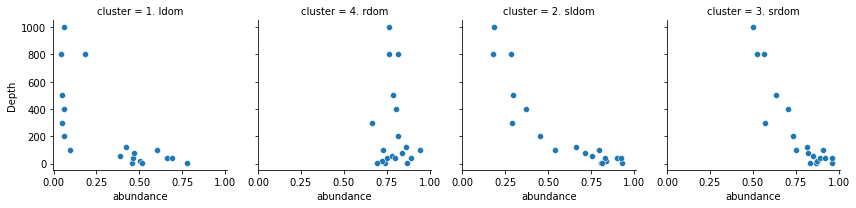

In [21]:

from operator import invert


norm_abundances=results_clustered[masterresults_df['File'].unique()].fillna(0)
norm_abundances=norm_abundances.div(norm_abundances.max(axis=1),axis=0)

depth=[]
for file in masterresults_df['File'].unique():
    d=samplelist[samplelist['File']==file]['Depth'].iloc[0]
    depth.append(d)

clustered_results=[]
for i in results_clustered['cluster'].unique():
    current=pd.DataFrame({'abundance':norm_abundances[results_clustered['cluster']==i].sum(axis=0)/len(results_clustered[results_clustered['cluster']==i]),'Depth':depth,'cluster':i})
    clustered_results.append(current)

clustered_results=pd.concat(clustered_results)

#g = sns.FacetGrid(data=clustered_results, col='cluster')
#g.ylim=(500, 0)
#g.map_dataframe(sns.scatterplot, y='Depth', x='abundance')


#for ax in g.axes[0]:
#    ax.invert_yaxis()

h = sns.relplot(data=clustered_results, col='cluster', x='abundance', y='Depth', kind='scatter', height=3)
for ax in h.axes[0]:
    ax.invert_yaxis()

#for ax in g.axes.ravel():
#    ax.invert_yaxis()



6740
0
0
0
0


<AxesSubplot:xlabel='Time', ylabel='Density'>

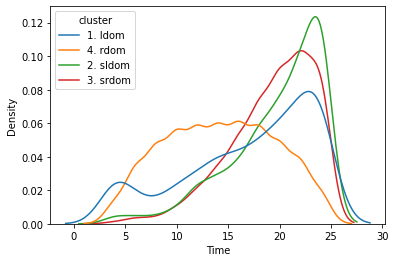

In [22]:
print(len(results_clustered))
print(len(results_clustered[results_clustered.cluster=='ldom']))
print(len(results_clustered[results_clustered.cluster=='sldom']))
print(len(results_clustered[results_clustered.cluster=='srdom']))
print(len(results_clustered[results_clustered.cluster=='rdom']))
sns.kdeplot(x='Time',hue='cluster', data=results_clustered, common_norm=False)


1. ldom
4. rdom
2. sldom
3. srdom


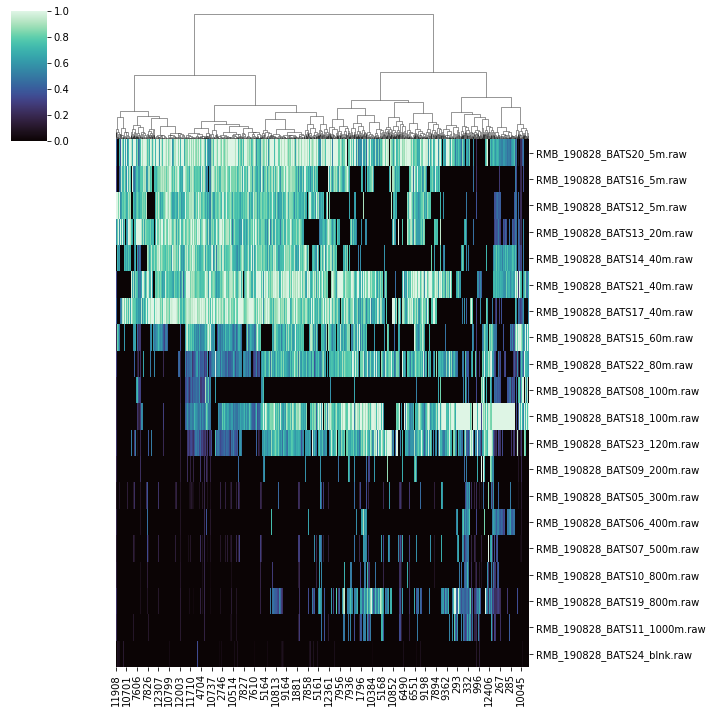

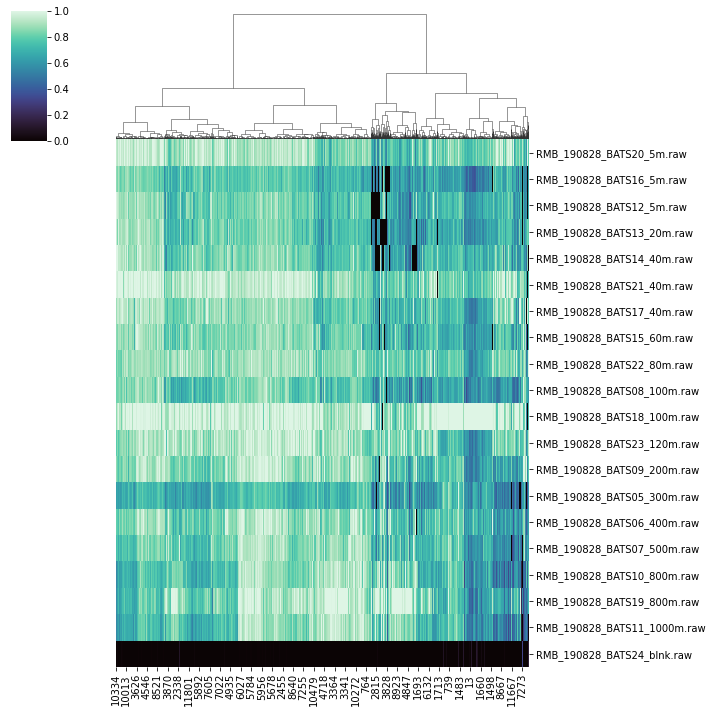

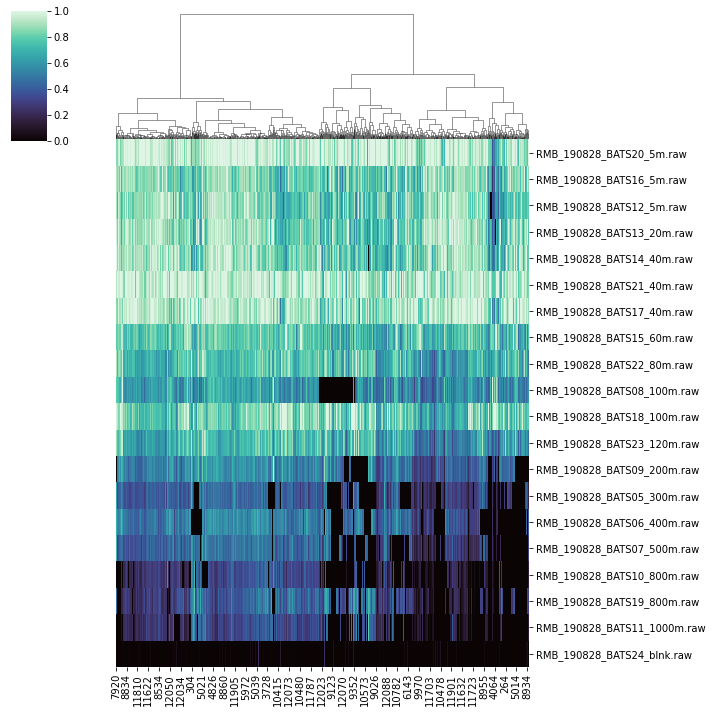

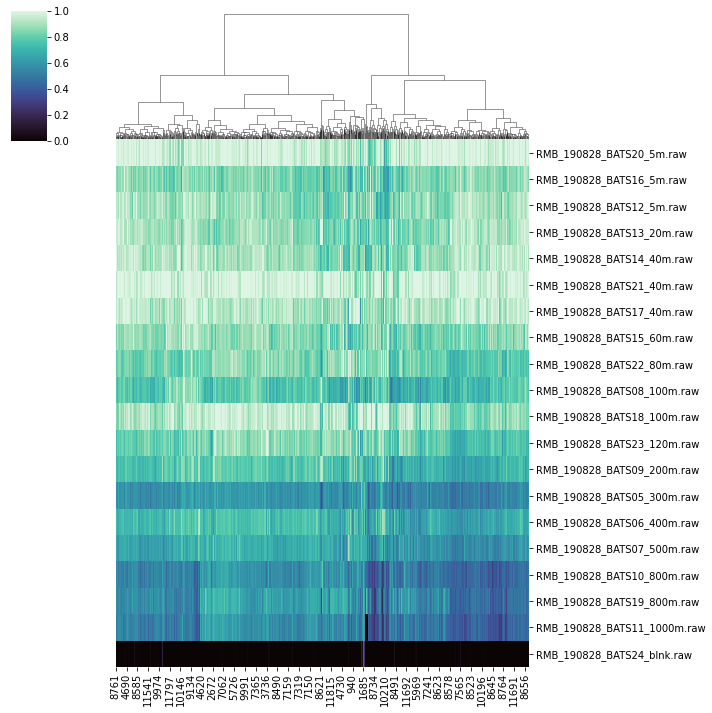

In [23]:
#fig, (ldom,sldom,srdom,rdom) = plt.subplots(ncols=4, gridspec_kw=dict(width_ratios=[4,1,1,1]))

for cluster in results_clustered['cluster'].unique():
    print(cluster)
    current=results_clustered[results_clustered['cluster']==cluster]
    current=current[masterresults_df['File'].unique()].fillna(0)
    current=current.div(current.max(axis=1),axis=0)
    clusterplot=norm_abundances
    current=current.transpose()
    current['Depth']=depth
    current=current.sort_values(by='Depth')
    current=current.drop(['Depth'],axis=1)
    sns.clustermap(current,row_cluster=False,cmap='mako',method=clustermethod,dendrogram_ratio=0.2)
    #sns.heatmap(current,cbar=False,cmap='mako',ax=cluster)


In [36]:
# Statistical tests of different variances. 
from scipy.stats import ranksums

print(ranksums(results_clustered[results_clustered['cluster']=='4. rdom']['H/C'],results_clustered[results_clustered['cluster']=='1. ldom']['H/C']))
print(ranksums(results_clustered[results_clustered['cluster']=='4. rdom']['O/C'],results_clustered[results_clustered['cluster']=='1. ldom']['O/C']))
print(ranksums(results_clustered[results_clustered['cluster']=='4. rdom']['N/C'],results_clustered[results_clustered['cluster']=='1. ldom']['N/C']))
print(ranksums(results_clustered[results_clustered['cluster']=='4. rdom']['m/z'],results_clustered[results_clustered['cluster']=='1. ldom']['m/z']))
print(ranksums(results_clustered[results_clustered['cluster']=='4. rdom']['Dispersity'],results_clustered[results_clustered['cluster']=='1. ldom']['Dispersity']))

RanksumsResult(statistic=-31.50024462411068, pvalue=8.619720423816056e-218)
RanksumsResult(statistic=0.459666824814269, pvalue=0.645755385501831)
RanksumsResult(statistic=6.243774072850302, pvalue=4.2713683964981104e-10)
RanksumsResult(statistic=-20.189043403647116, pvalue=1.2220767384612507e-90)
RanksumsResult(statistic=2.2078731800441243, pvalue=0.027253114916747933)


In [345]:
print(len(dispersity))
print(len(results_clustered))



7184
7184


<AxesSubplot:xlabel='dispersity', ylabel='Density'>

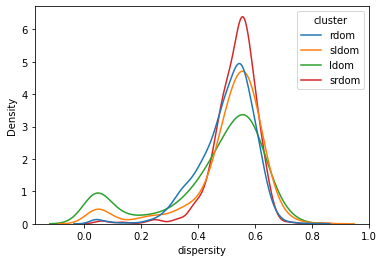

In [348]:
sns.kdeplot(x='dispersity',hue='cluster', data=results_clustered, common_norm=False, legend=True)


In [25]:
current=results_clustered.iloc[0]
time=[0,2]+current.Time
file=current.File
mass=current['m/z']
print(mass)

EIC=MSfiles[file].get_eics(target_mzs=[mass],tic_data={},peak_detection=False,smooth=False)
chroma=pd.DataFrame({'EIC':EIC[0][mass].eic,'time':EIC[0][mass].time})
chroma=chroma[chroma['time'].between(time[0],time[1])]
chroma=chroma.sort_values(by='EIC',ascending=False)

dispersity=[]


dispersity.append(chroma[chroma.cumsum()['EIC']<0.5*chroma.sum()['EIC']].time.std())
print(dispersity)


794.4333189156771
[0.5246008445685089]


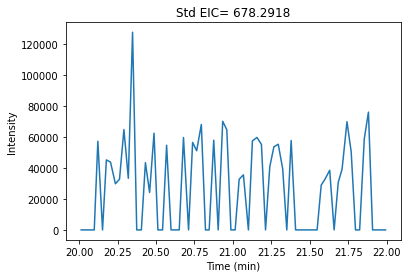

14
72
[0.5246008445685089]


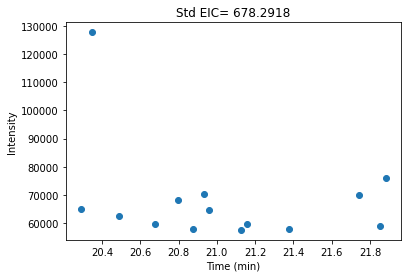

In [27]:
current=results_clustered[results_clustered['cluster']=='1. ldom'].iloc[0]
time=[0,2]+current.Time
file=current.File
mass=current['m/z']

EIC=MSfiles[file].get_eics(target_mzs=[mass],tic_data={},peak_detection=False,smooth=False)
chroma=pd.DataFrame({'EIC':EIC[0][mass].eic,'time':EIC[0][mass].time})
chroma=chroma[chroma['time'].between(time[0],time[1])]

dispersity=[]

fig=plt.figure()
ax=plt.subplot(111)
ax.set(xlabel='Time (min)',ylabel='Intensity',title='Std EIC= '+str(stdmass))

ax.plot(chroma['time'],chroma['EIC'],label=file)

plt.show()
chroma=chroma.sort_values(by='EIC',ascending=False)
chroma_sub=chroma[chroma.cumsum(axis=0)['EIC']<0.5*chroma.sum(axis=0)['EIC']]

print(len(chroma_sub))
[print(len(chroma))]


fig=plt.figure()
ax=plt.subplot(111)
ax.set(xlabel='Time (min)',ylabel='Intensity',title='Std EIC= '+str(stdmass))

ax.scatter(chroma_sub['time'],chroma_sub['EIC'],label=file)

dispersity.append(chroma_sub.time.std())
print(dispersity)


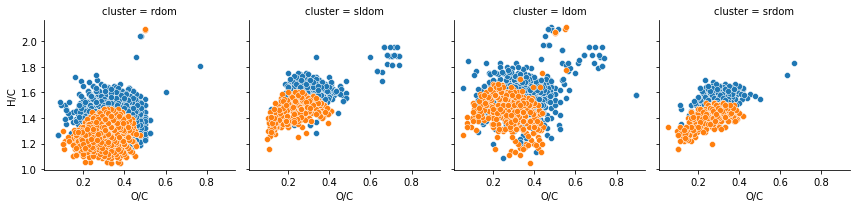

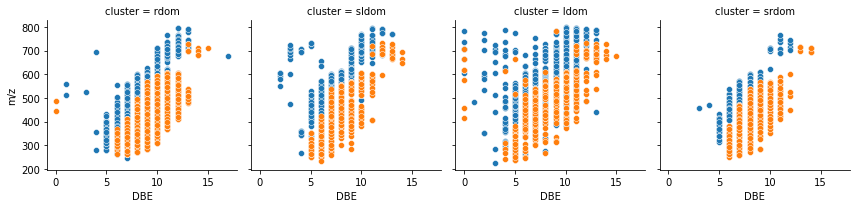

In [248]:
g = sns.FacetGrid(results_clustered, col="cluster", hue='mol_class')
g.map(sns.scatterplot,'O/C','H/C')

g = sns.FacetGrid(results_clustered, col="cluster", hue='mol_class')
g.map(sns.scatterplot,'DBE','m/z')


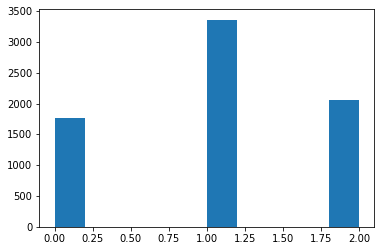

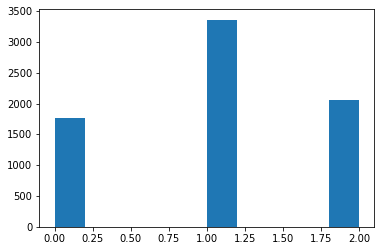

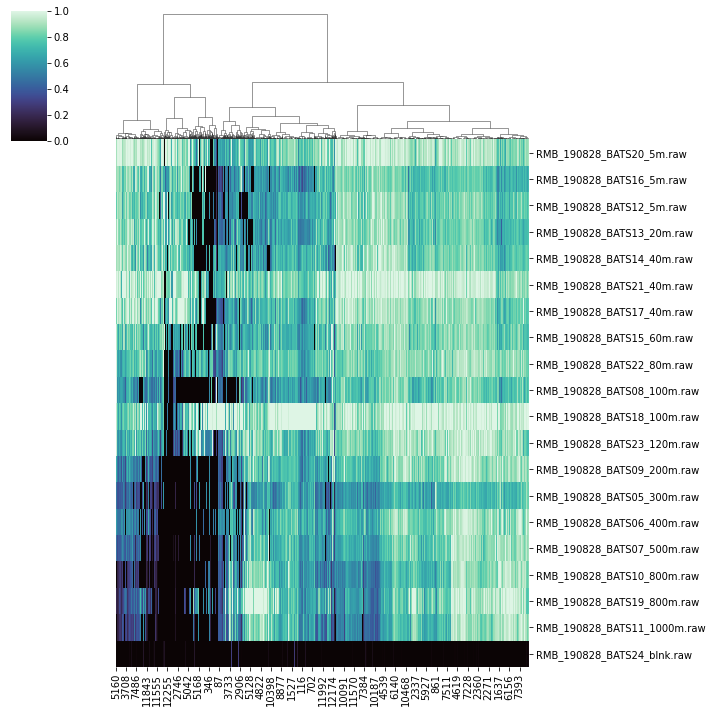

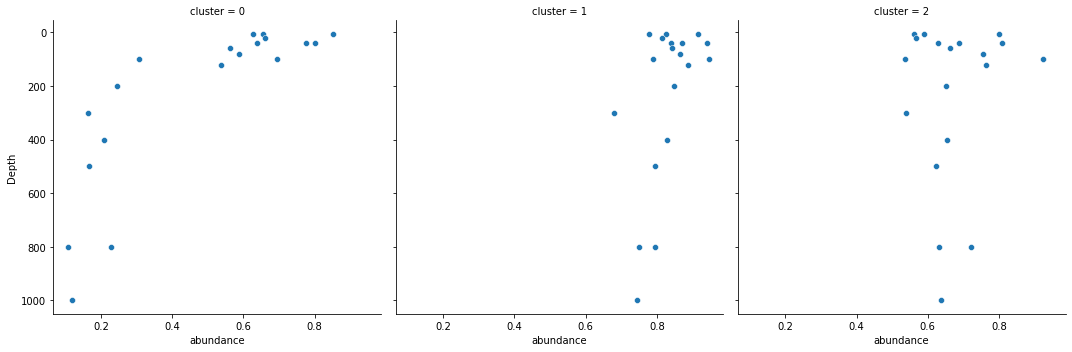

In [220]:

##################

results_clustered2=results_clustered
nclusters=3
norm_abundances2=results_clustered2[masterresults_df['File'].unique()].fillna(0)
norm_abundances2=norm_abundances2.div(norm_abundances2.max(axis=1),axis=0)


cluster = AgglomerativeClustering(n_clusters=nclusters,affinity='euclidean',linkage=clustermethod)
cluster.fit_predict(norm_abundances2)

results_clustered2['cluster']=cluster.labels_

plt.hist(results_clustered.cluster)
plt.show()

plt.hist(results_clustered2.cluster)

clustered_results=[]
for i in results_clustered2['cluster'].unique():
    current=pd.DataFrame({'abundance':norm_abundances2[results_clustered2['cluster']==i].sum(axis=0)/len(results_clustered2[results_clustered2['cluster']==i]),'Depth':depth,'cluster':i})
    clustered_results.append(current)

clustered_results=pd.concat(clustered_results)
clustered_results=clustered_results.sort_values(by='Depth',ascending=True)

#Make cluster heatmap
clusterplot=norm_abundances2
clusterplot=clusterplot.transpose()
clusterplot['Depth']=depth
clusterplot=clusterplot.sort_values(by='Depth')
clusterplot=clusterplot.drop(['Depth'],axis=1)
sns.clustermap(clusterplot,row_cluster=False,cmap='mako',method=clustermethod)

g = sns.relplot(data=clustered_results, col='cluster', x='abundance', y='Depth', kind='scatter')
for ax in g.axes[0]:
    ax.invert_yaxis()

plt.show()



50


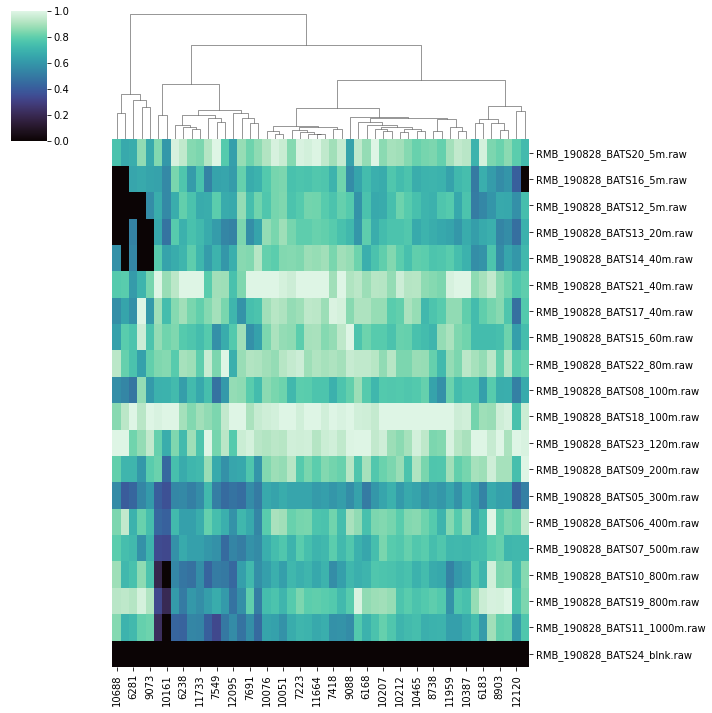

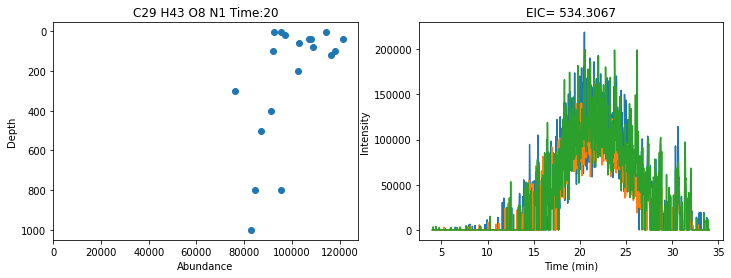

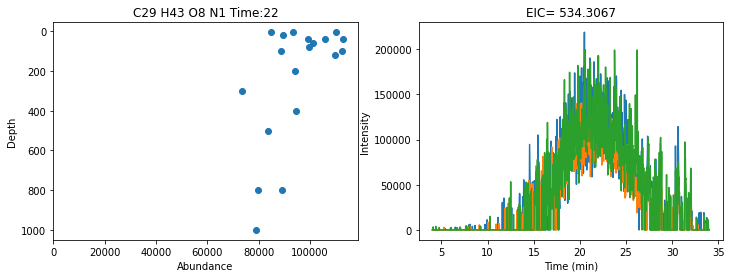

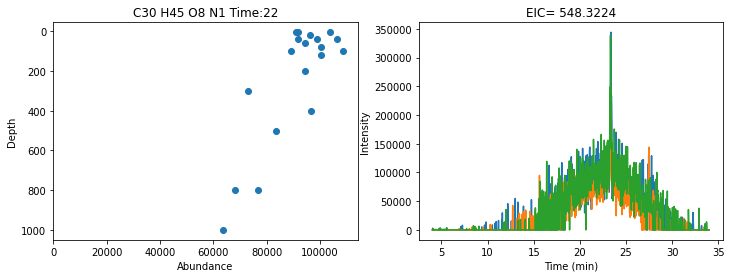

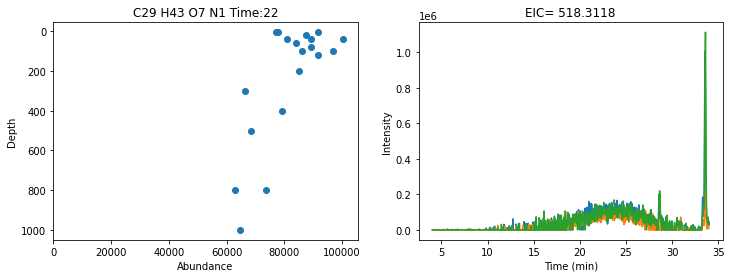

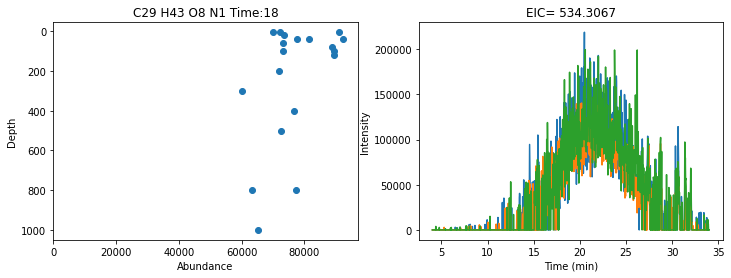

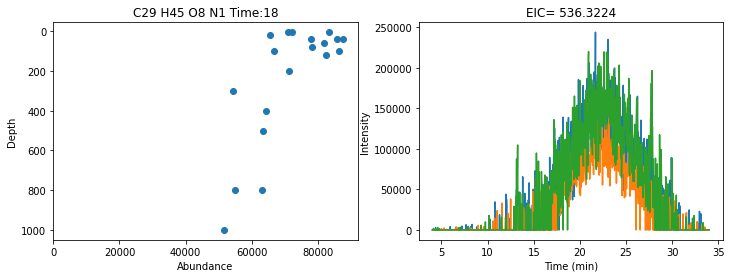

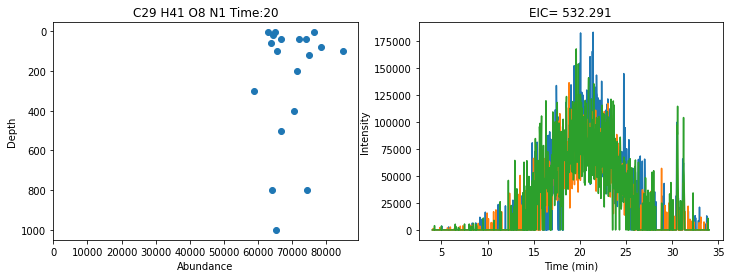

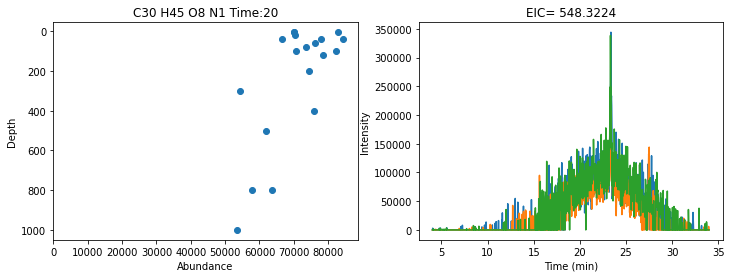

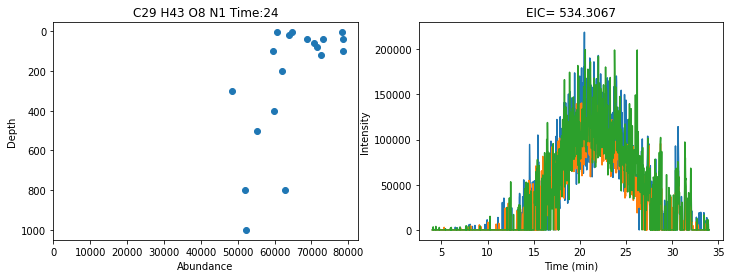

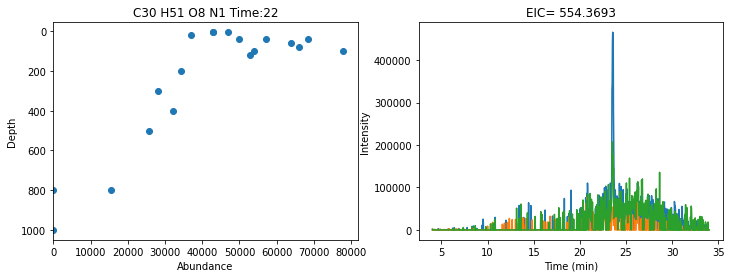

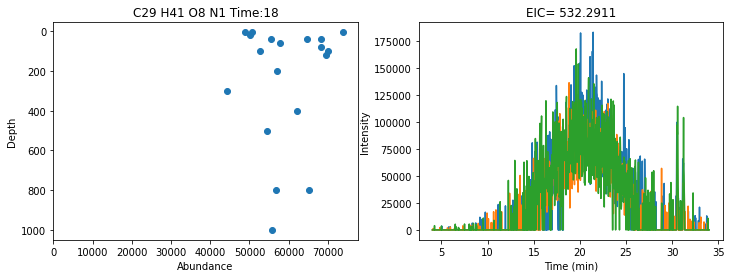

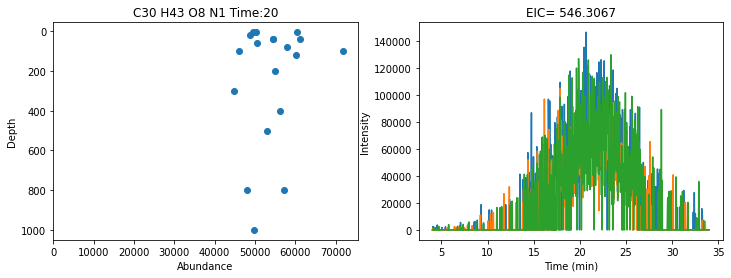

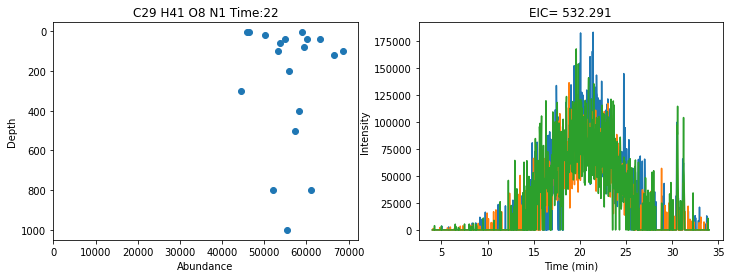

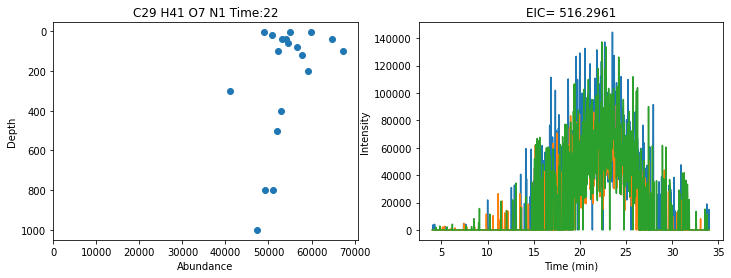

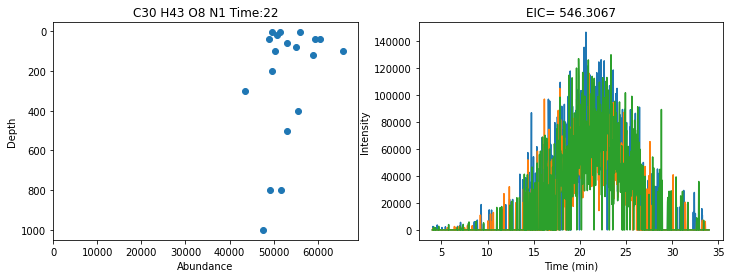

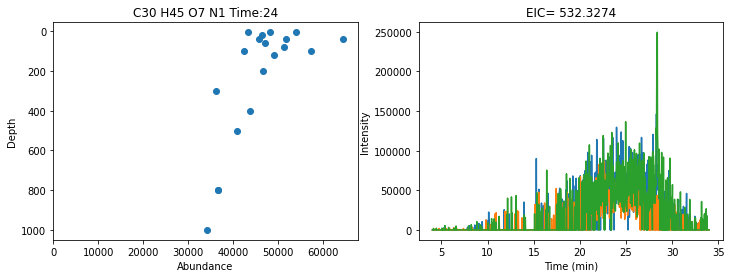

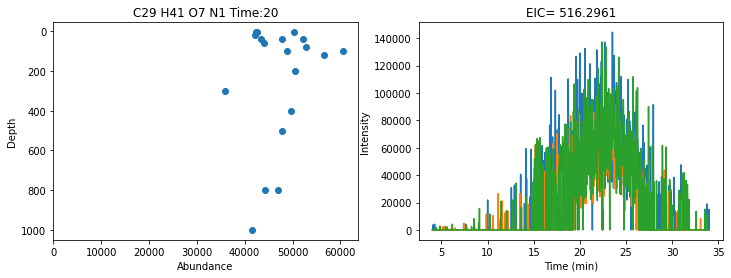

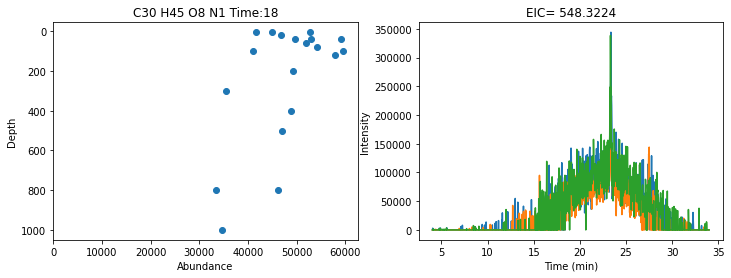

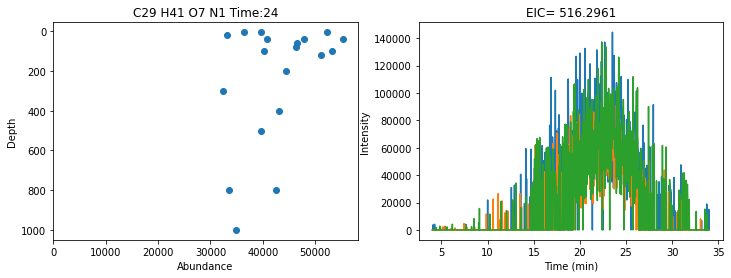

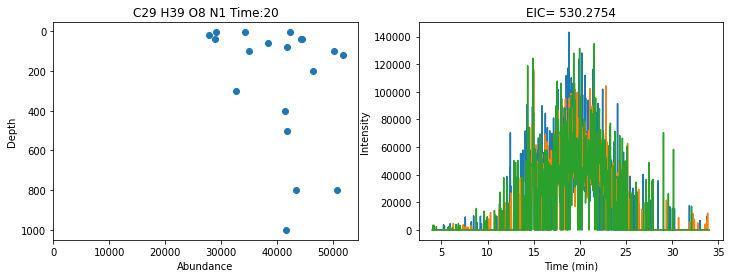

In [34]:
#Investigate RDOM
dom_cluster=results_clustered[(results_clustered['O']>6) & (results_clustered['O']<9) & (results_clustered['N']==1) & (results_clustered['C']>28) & (results_clustered['cluster']=='4. rdom')]

abundances=dom_cluster[masterresults_df['File'].unique()].fillna(0)
clusterplot=abundances.transpose()
print(len(abundances))
for column in clusterplot:
    current=clusterplot[column]
    clusterplot[column]=(current-min(current))/(max(current)-min(current))

clusterplot['Depth']=depth
clusterplot=clusterplot.sort_values(by='Depth')
clusterplot=clusterplot.drop(['Depth'],axis=1)
sns.clustermap(clusterplot,row_cluster=False,cmap='mako',method=clustermethod)

investigate_results=dom_cluster.sort_values(by='Peak Height',ascending=False).reset_index()
for i in range(0,20):
    result=investigate_results.loc[i]
    intensity=result[samplelist['File'].unique()].fillna(0)
    #print(result)
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(12,4)
    ax1.scatter(x=intensity,y=depth)
    #ax1.set(xlabel='Abundance',xlim=[0,max(intensity)*1.05],ylabel='Depth',title=result['Molecular Formula']+' ' + str(result['cluster'])+ ' Time:' + str(result['Time']))
    ax1.set(xlabel='Abundance',xlim=[0,max(intensity)*1.05],ylabel='Depth',title=result['Molecular Formula']+' Time:' + str(result['Time']))
    ax1.invert_yaxis()


    stdmass=result['m/z']
    std_timerange=[4,34]

    area=[]
    rt=[]
    ax2.set(xlabel='Time (min)',ylabel='Intensity',title='EIC= '+str(stdmass.round(4)))

    files=['RMB_190828_BATS18_100m.raw', 'RMB_190828_BATS19_800m.raw', 'RMB_190828_BATS20_5m.raw']
    #for file in MSfiles.keys():
    for file in files:

        EIC=MSfiles[file].get_eics(target_mzs=[stdmass],tic_data={},peak_detection=False,smooth=False)
        df=pd.DataFrame({'EIC':EIC[0][stdmass].eic,'time':EIC[0][stdmass].time})
        df_sub=df[df['time'].between(std_timerange[0],std_timerange[1])]
        area.append(sum(df_sub['EIC']))
        rt.append(df_sub.time[df_sub.EIC==df_sub.EIC.max()].max())
        ax2.plot(df_sub['time'],df_sub['EIC'],label=file[11:])

    #ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
#plt.savefig('Fig1_qcplot.eps', format='eps')


292


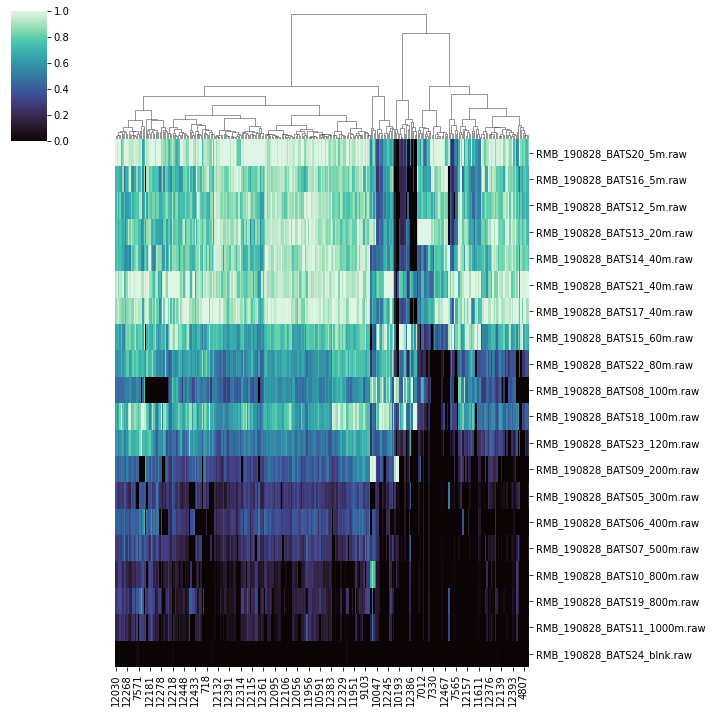

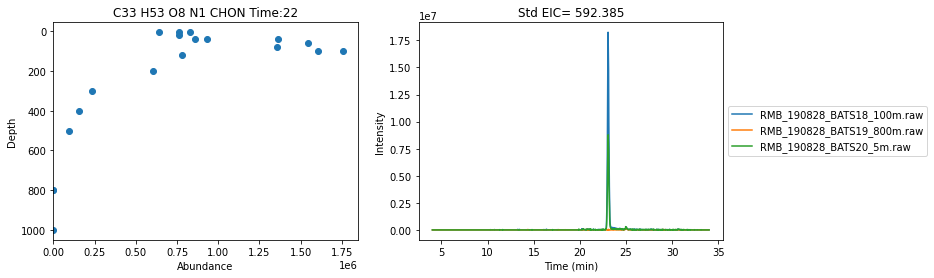

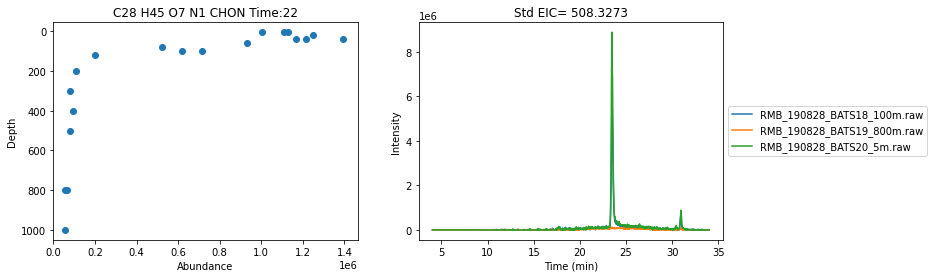

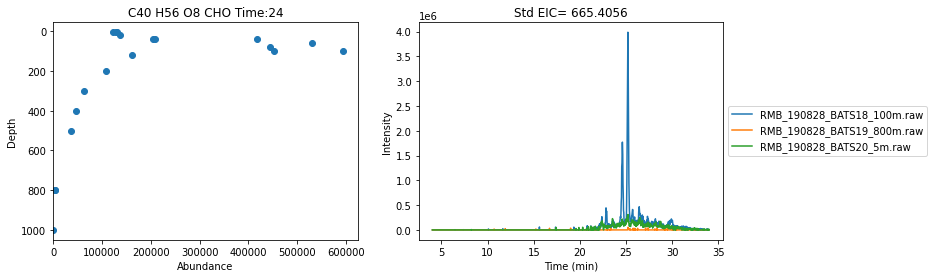

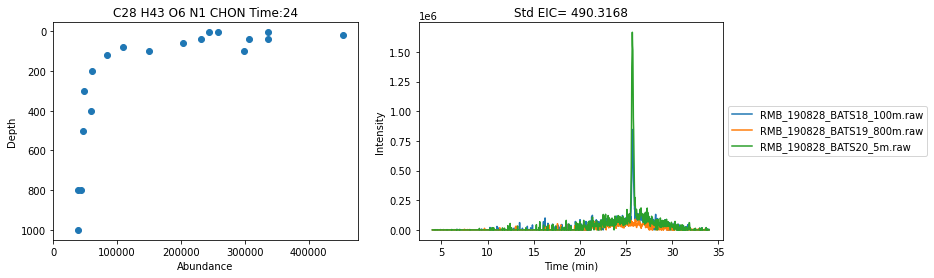

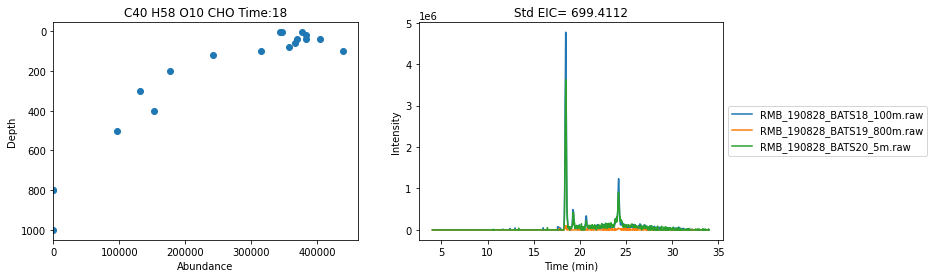

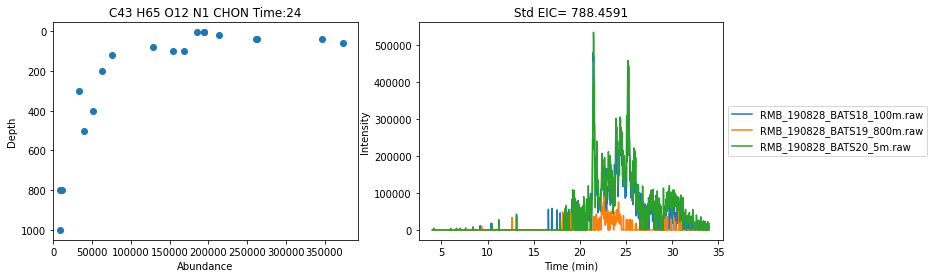

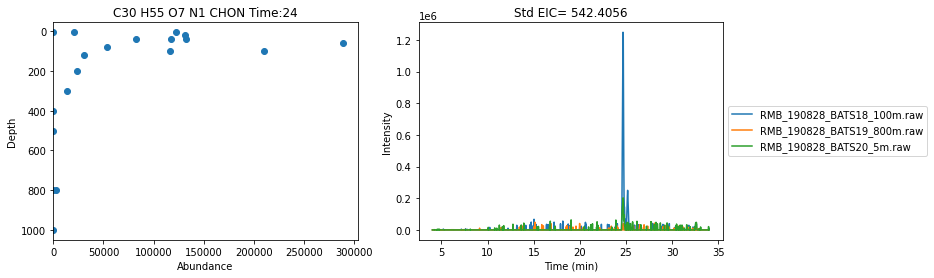

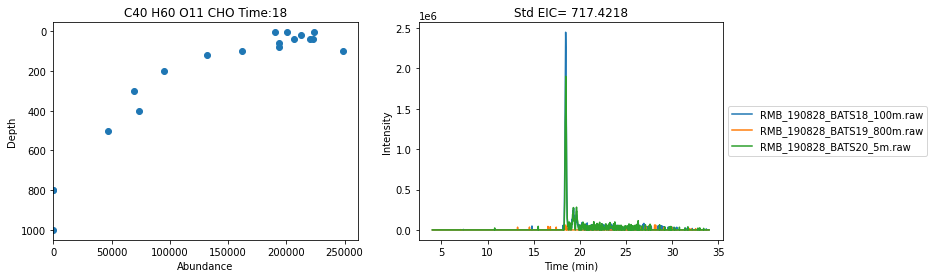

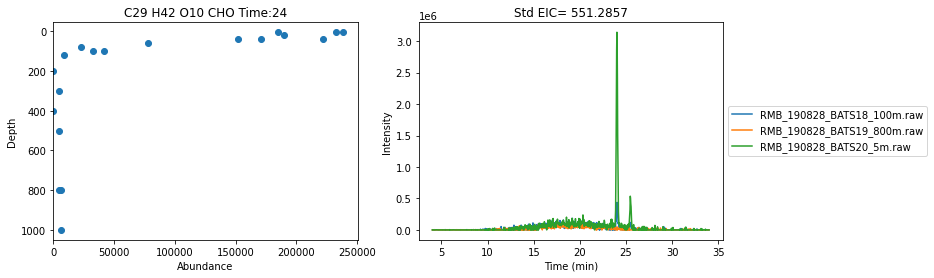

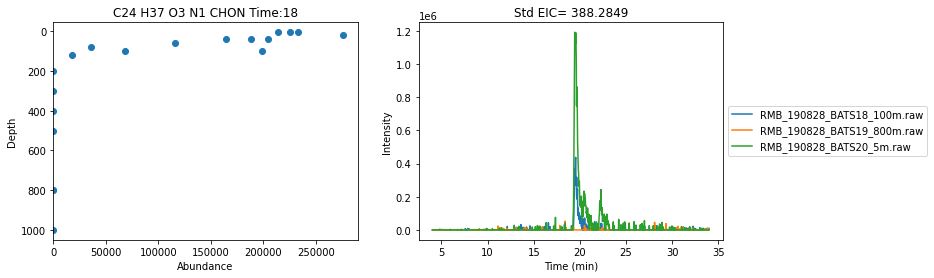

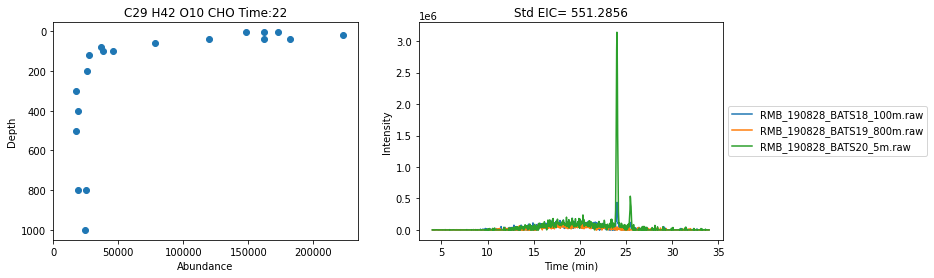

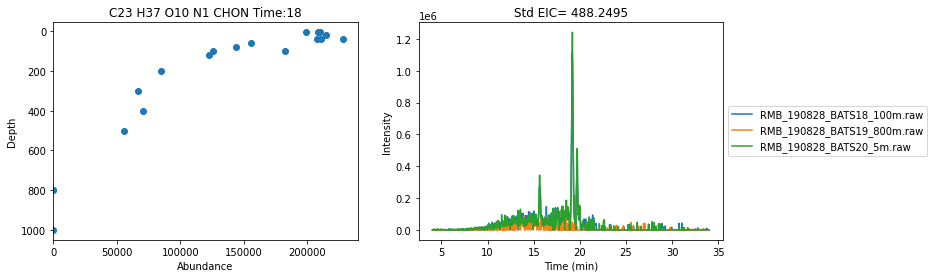

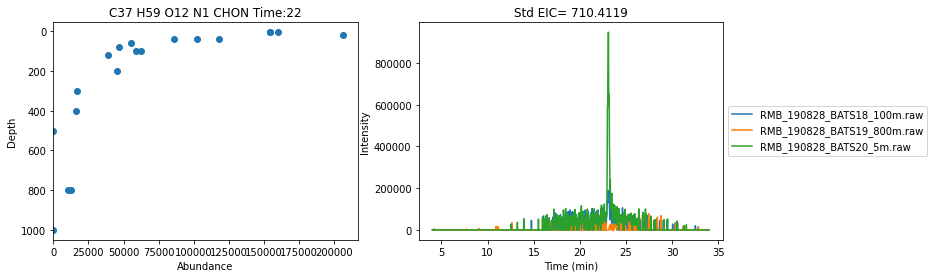

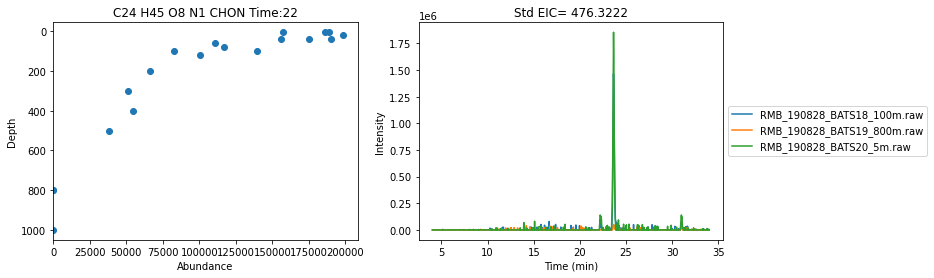

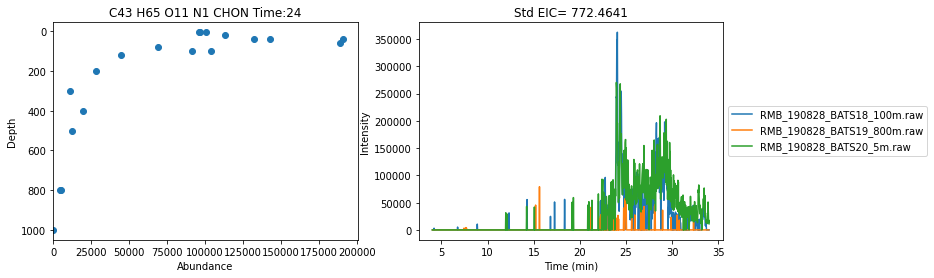

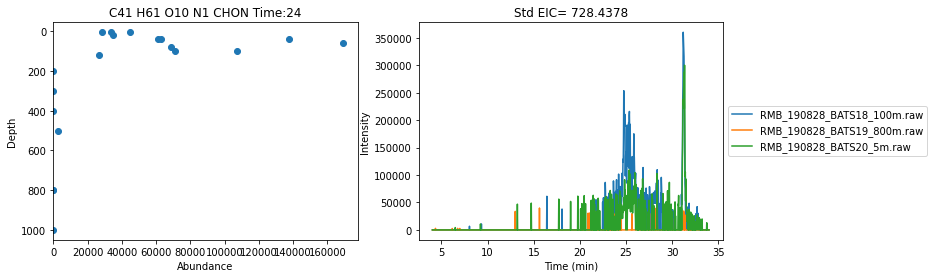

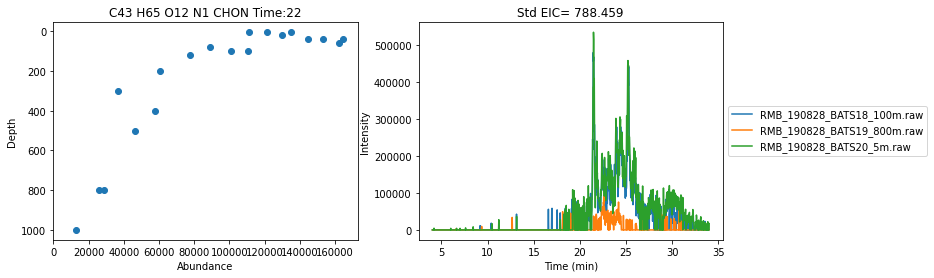

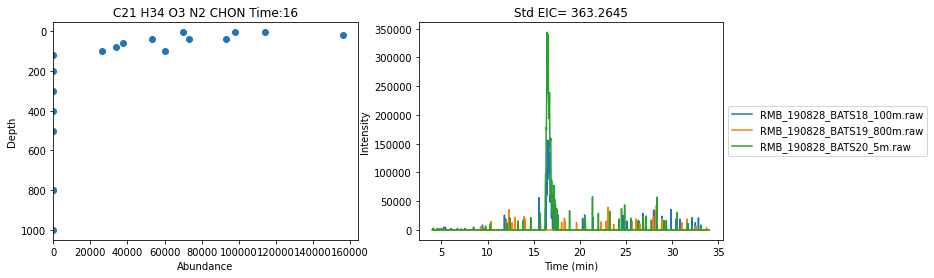

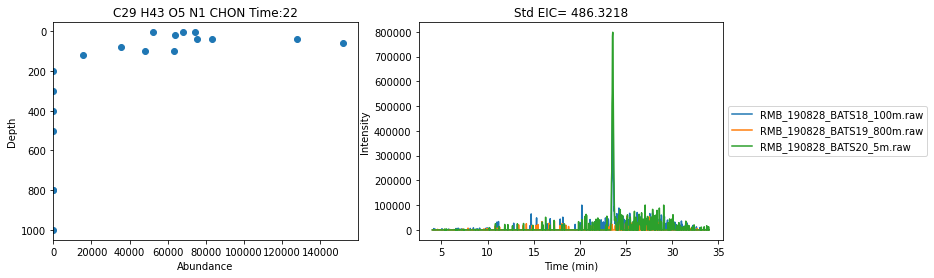

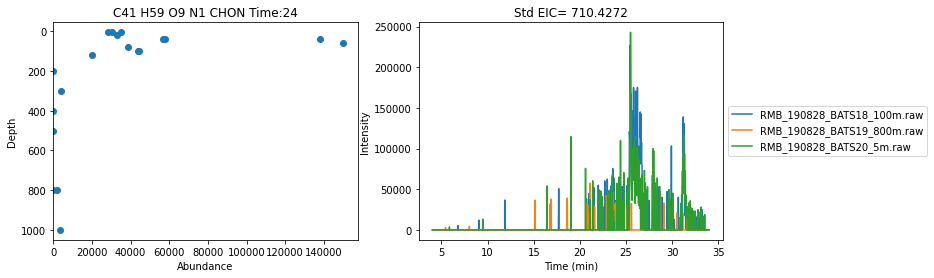

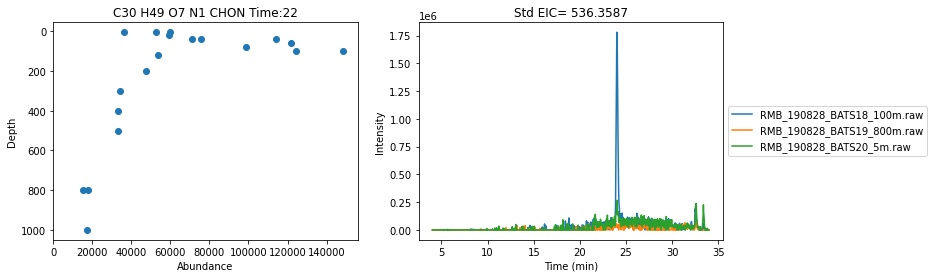

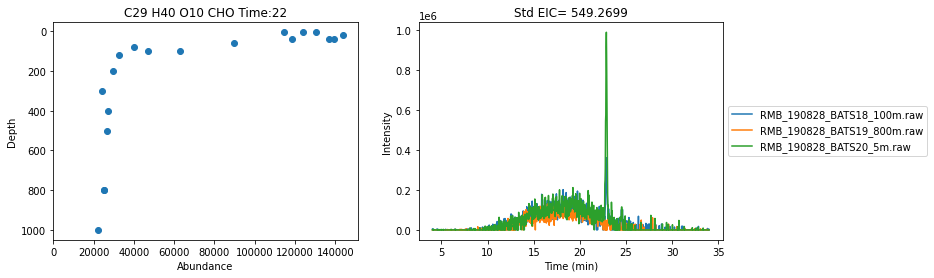

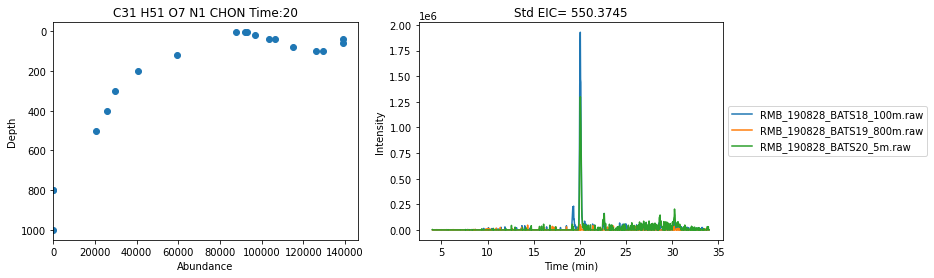

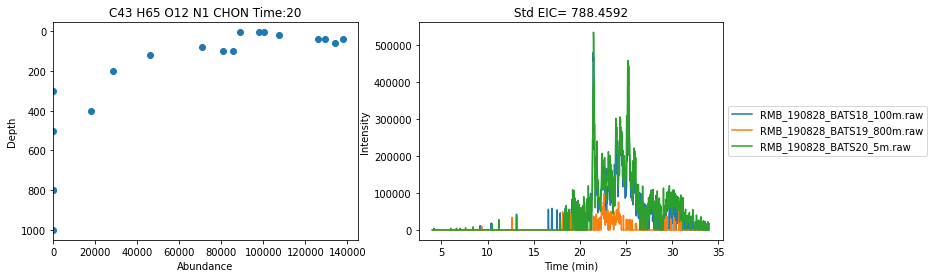

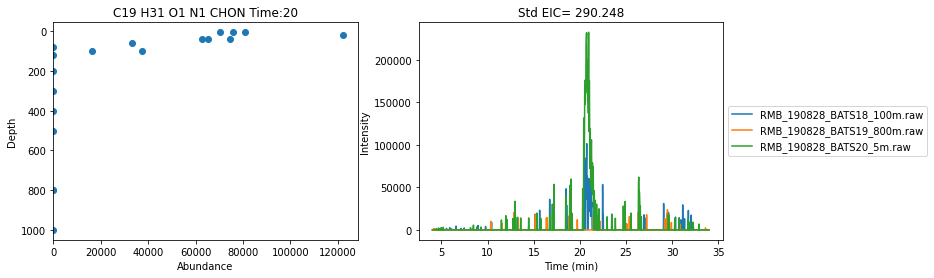

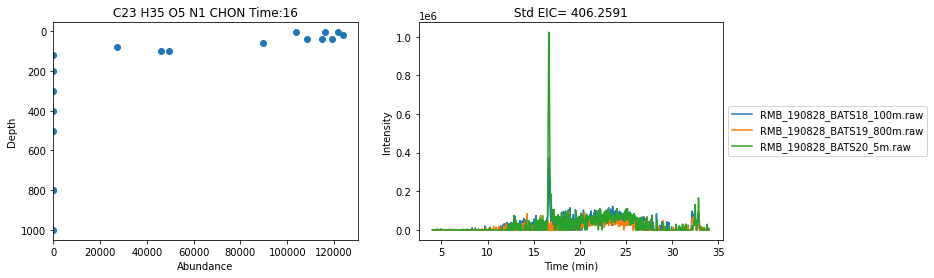

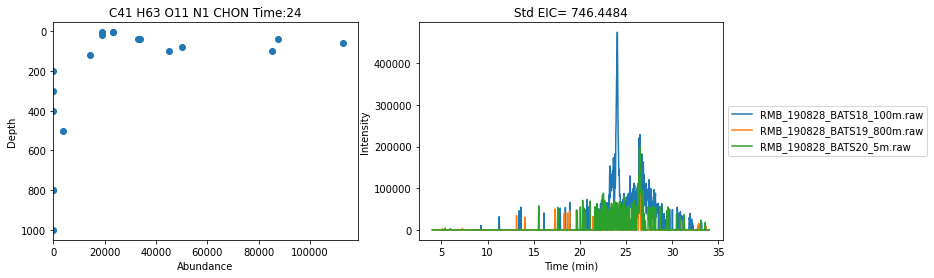

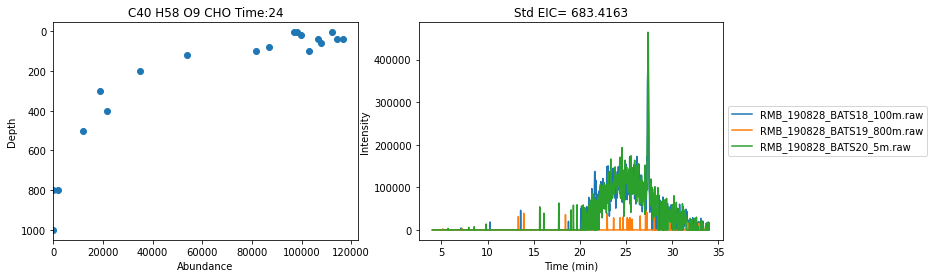

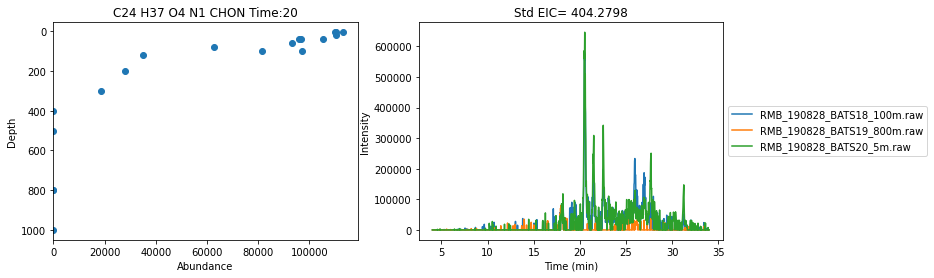

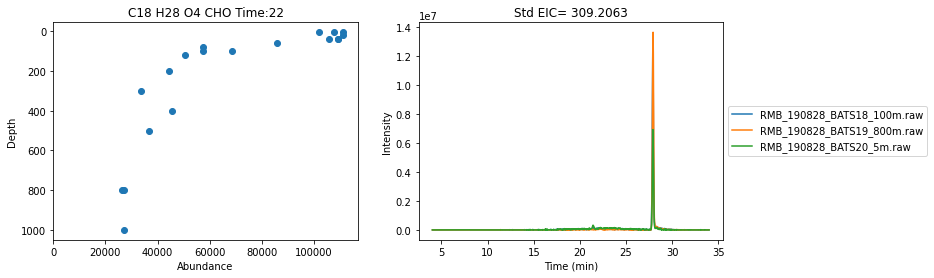

In [144]:
#Investigate Surface DOM
dom_cluster=results_clustered[results_clustered['cluster']=='surface']

abundances=dom_cluster[masterresults_df['File'].unique()].fillna(0)
clusterplot=abundances.transpose()
print(len(abundances))
for column in clusterplot:
    current=clusterplot[column]
    clusterplot[column]=(current-min(current))/(max(current)-min(current))

clusterplot['Depth']=depth
clusterplot=clusterplot.sort_values(by='Depth')
clusterplot=clusterplot.drop(['Depth'],axis=1)
sns.clustermap(clusterplot,row_cluster=False,cmap='mako',method=clustermethod)

investigate_results=dom_cluster.sort_values(by='Peak Height',ascending=False).reset_index()
for i in range(0,30):
    result=investigate_results.loc[i]
    intensity=result[samplelist['File'].unique()].fillna(0)
    #print(result)
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(12,4)
    ax1.scatter(x=intensity,y=depth)
    ax1.set(xlabel='Abundance',xlim=[0,max(intensity)*1.05],ylabel='Depth',title=result['Molecular Formula']+' ' + result['mol_class']+ ' Time:' + str(result['Time']))
    ax1.invert_yaxis()


    stdmass=result['m/z']
    std_timerange=[4,34]

    area=[]
    rt=[]
    ax2.set(xlabel='Time (min)',ylabel='Intensity',title='Std EIC= '+str(stdmass.round(4)))

    files=['RMB_190828_BATS18_100m.raw', 'RMB_190828_BATS19_800m.raw', 'RMB_190828_BATS20_5m.raw']
    #for file in MSfiles.keys():
    for file in files:

        EIC=MSfiles[file].get_eics(target_mzs=[stdmass],tic_data={},peak_detection=False,smooth=False)
        df=pd.DataFrame({'EIC':EIC[0][stdmass].eic,'time':EIC[0][stdmass].time})
        df_sub=df[df['time'].between(std_timerange[0],std_timerange[1])]
        area.append(sum(df_sub['EIC']))
        rt.append(df_sub.time[df_sub.EIC==df_sub.EIC.max()].max())
        ax2.plot(df_sub['time'],df_sub['EIC'],label=file)

    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
#plt.savefig('Fig1_qcplot.eps', format='eps')


533


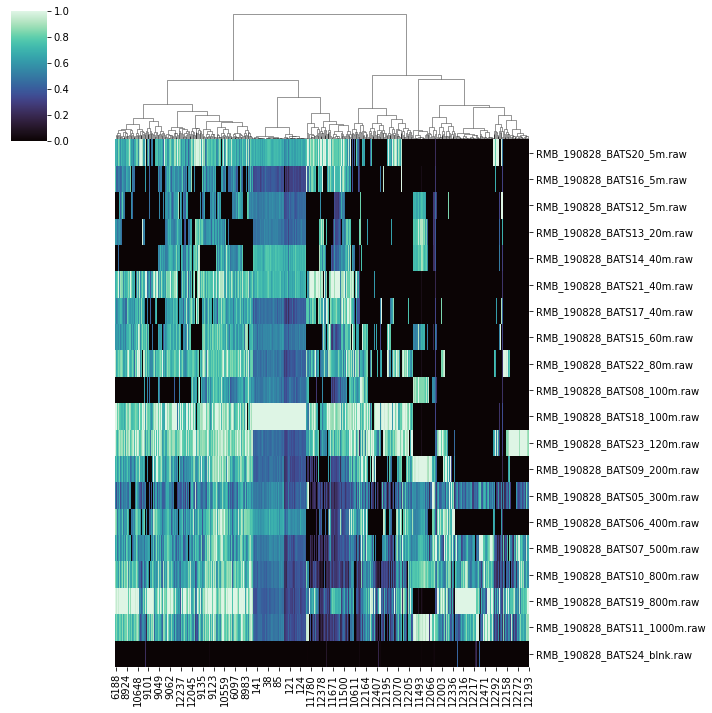

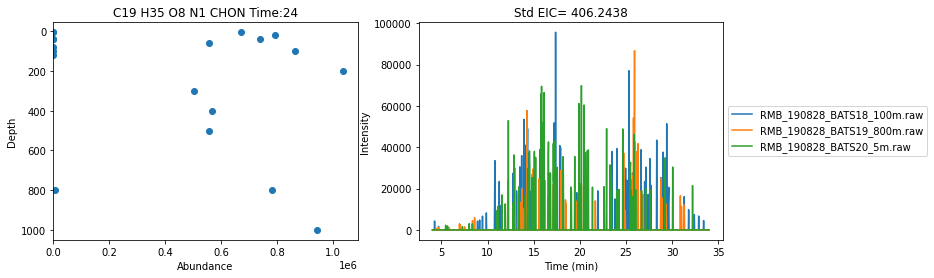

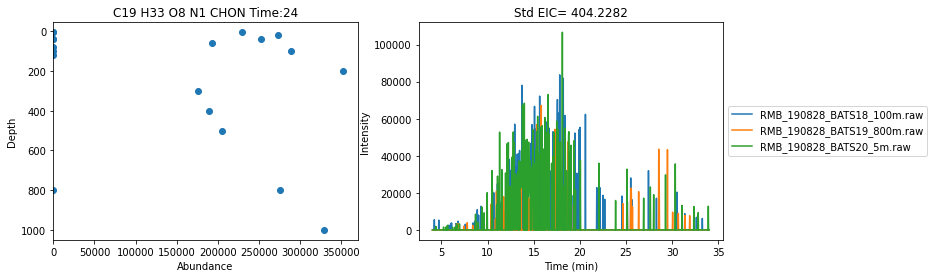

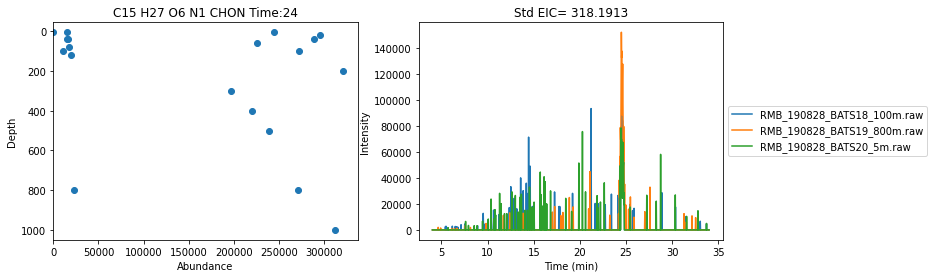

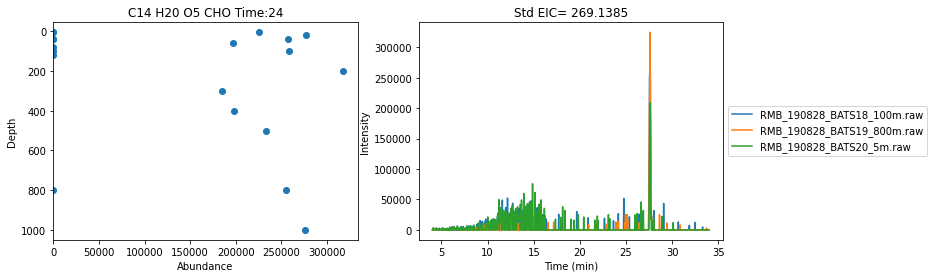

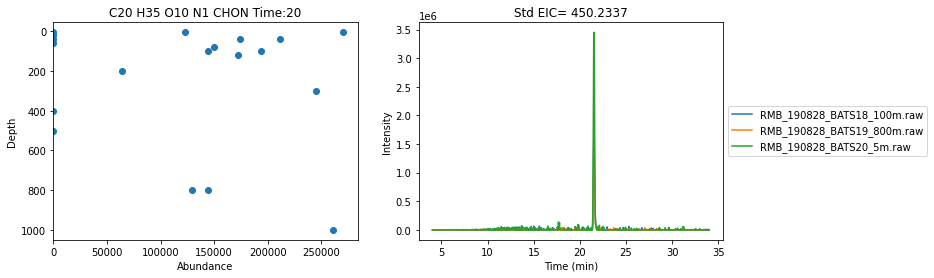

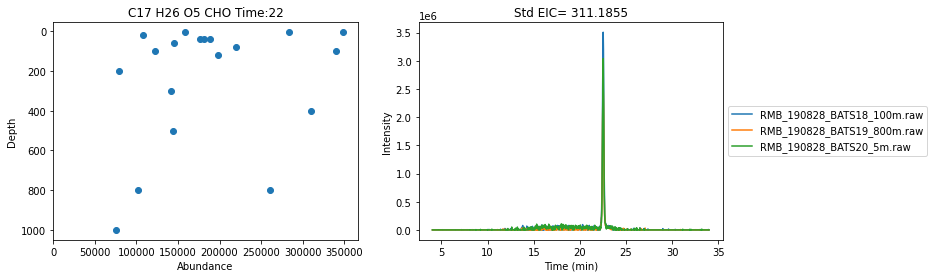

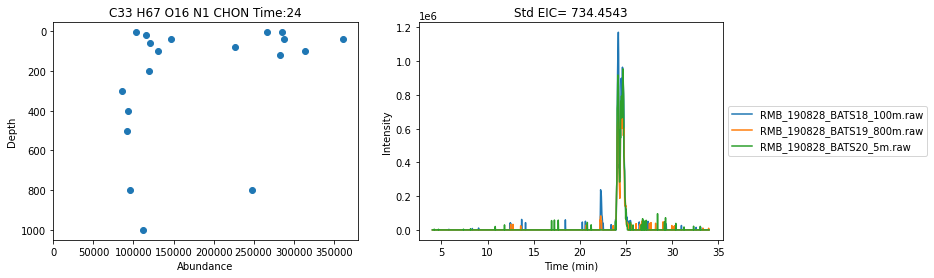

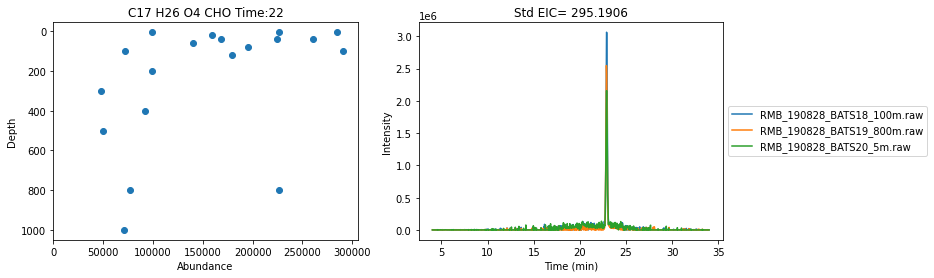

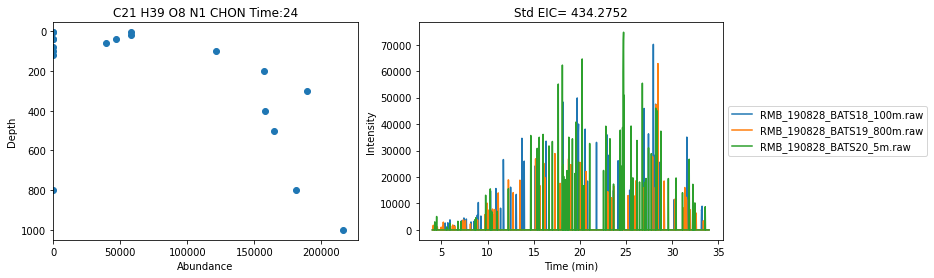

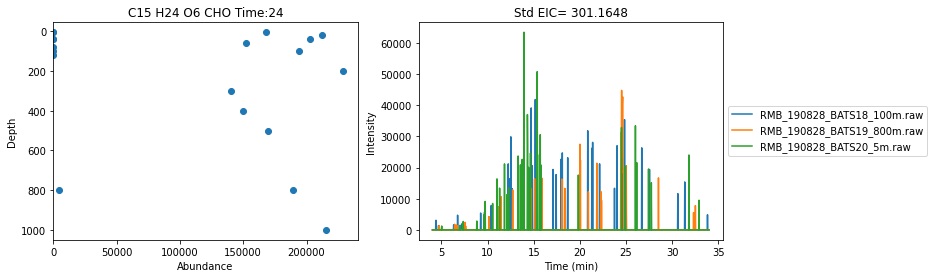

In [143]:
#Investigate Deep DOM
dom_cluster=results_clustered[results_clustered['cluster']=='deep']

abundances=dom_cluster[masterresults_df['File'].unique()].fillna(0)
clusterplot=abundances.transpose()
print(len(abundances))
for column in clusterplot:
    current=clusterplot[column]
    clusterplot[column]=(current-min(current))/(max(current)-min(current))

clusterplot['Depth']=depth
clusterplot=clusterplot.sort_values(by='Depth')
clusterplot=clusterplot.drop(['Depth'],axis=1)
sns.clustermap(clusterplot,row_cluster=False,cmap='mako',method=clustermethod)

investigate_results=dom_cluster.sort_values(by='Peak Height',ascending=False).reset_index()
for i in range(0,10):
    result=investigate_results.loc[i]
    intensity=result[samplelist['File'].unique()].fillna(0)
    #print(result)
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(12,4)
    ax1.scatter(x=intensity,y=depth)
    ax1.set(xlabel='Abundance',xlim=[0,max(intensity)*1.05],ylabel='Depth',title=result['Molecular Formula']+' ' + result['mol_class']+ ' Time:' + str(result['Time']))
    ax1.invert_yaxis()


    stdmass=result['m/z']
    std_timerange=[4,34]

    area=[]
    rt=[]
    ax2.set(xlabel='Time (min)',ylabel='Intensity',title='Std EIC= '+str(stdmass.round(4)))

    files=['RMB_190828_BATS18_100m.raw', 'RMB_190828_BATS19_800m.raw', 'RMB_190828_BATS20_5m.raw']
    #for file in MSfiles.keys():
    for file in files:

        EIC=MSfiles[file].get_eics(target_mzs=[stdmass],tic_data={},peak_detection=False,smooth=False)
        df=pd.DataFrame({'EIC':EIC[0][stdmass].eic,'time':EIC[0][stdmass].time})
        df_sub=df[df['time'].between(std_timerange[0],std_timerange[1])]
        area.append(sum(df_sub['EIC']))
        rt.append(df_sub.time[df_sub.EIC==df_sub.EIC.max()].max())
        ax2.plot(df_sub['time'],df_sub['EIC'],label=file)

    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
#plt.savefig('Fig1_qcplot.eps', format='eps')
